In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from scipy.stats import pearsonr

In [73]:
def analyze_energy_levels_correlation(data, start_date, end_date, column, shift_days=0):
    # Convert to datetime
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Adjust start and end dates based on the shift
    if shift_days > 0:
        start_date += pd.Timedelta(days=shift_days)  # Start later if shifting backwards
    elif shift_days < 0:
        end_date += pd.Timedelta(days=shift_days)  # End sooner if shifting forwards

    # Filter data based on adjusted dates
    filtered_data = data.replace('-', np.nan)
    filtered_data = filtered_data[(filtered_data.index >= start_date) & (filtered_data.index <= end_date)]

    # Exclude days with all missing energy data for the first two sessions
    filtered_data = filtered_data.dropna(subset=['session_1_1', 'session_1_2', 'session_2_1', 'session_2_2'], how='all')

    # Calculate the average energy levels for the first two work sessions
    filtered_data['avg_energy_session_1'] = filtered_data[['session_1_1', 'session_1_2']].mean(axis=1, skipna=True)
    filtered_data['avg_energy_session_2'] = filtered_data[['session_2_1', 'session_2_2']].mean(axis=1, skipna=True)
    filtered_data['avg_energy'] = filtered_data[['avg_energy_session_1', 'avg_energy_session_2']].mean(axis=1, skipna=True)

    # Shift the specified column data by the number of days requested
    filtered_data[column] = filtered_data[column].shift(periods=-shift_days)

    # Drop rows where 'avg_energy' or the shifted column is NaN
    filtered_data = filtered_data.dropna(subset=[column, 'avg_energy'])

    # Calculate the correlation between the shifted column and average energy levels
    correlation, p_value = pearsonr(filtered_data[column], filtered_data['avg_energy'])

    print(f"Pearson correlation between shifted {column} and average energy levels: {correlation:.3f}")
    print(f"P-value: {p_value:.3f}")

    # Plot the average energy levels with different values of the specified column
    plt.figure(figsize=(14, 6))
    sns.scatterplot(x=filtered_data[column], y=filtered_data['avg_energy'])
    plt.title(f'Correlation between Shifted {column} and Average Energy Levels')
    plt.xlabel(column.capitalize())
    plt.ylabel('Average Energy')
    plt.tight_layout()
    plt.show()

    # Scatter plot of the energy levels indexed by date
    plt.figure(figsize=(14, 6))
    plt.plot(filtered_data.index, filtered_data['avg_energy'], 'o', label='Average Energy')
    plt.title('Average Energy Levels Indexed by Date')
    plt.xlabel('Date')
    plt.ylabel('Average Energy')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
# analyze_energy_levels_correlation(data, '2024-05-28', '2024-06-13', 'sleep_duration', shift_days=-1)

In [56]:

def analyze_energy_levels(data, start_date, end_date, column):
    # Data Preparation
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Filter data based on dates
    filtered_data = data.replace('-', np.nan)
    filtered_data = filtered_data[(filtered_data.index >= start_date) & (filtered_data.index <= end_date)]

    # Exclude days with all missing energy data for the first two sessions
    filtered_data = filtered_data.dropna(subset=['session_1_1', 'session_1_2', 'session_2_1', 'session_2_2'], how='all')

    # Calculate the average energy levels for the first two work sessions
    filtered_data['avg_energy_session_1'] = filtered_data[['session_1_1', 'session_1_2']].mean(axis=1, skipna=True)
    filtered_data['avg_energy_session_2'] = filtered_data[['session_2_1', 'session_2_2']].mean(axis=1, skipna=True)
    filtered_data['avg_energy'] = filtered_data[['avg_energy_session_1', 'avg_energy_session_2']].mean(axis=1, skipna=True)

    # Drop rows where 'avg_energy' is NaN (if both sessions are missing)
    filtered_data = filtered_data.dropna(subset=['avg_energy'])

    # Plot the average energy levels with and without the given column (e.g., Potassium) intake
    plt.figure(figsize=(14, 6))
    sns.histplot(filtered_data[filtered_data[column] == 1]['avg_energy'], color='blue', label=f'With {column.capitalize()}', kde=True, stat="density")
    sns.histplot(filtered_data[filtered_data[column] == 0]['avg_energy'], color='red', label=f'Without {column.capitalize()}', kde=True, stat="density")
    plt.title('Average Energy Levels')
    plt.xlabel('Average Energy')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Scatter plot of the energy levels indexed by date
    plt.figure(figsize=(14, 6))
    plt.plot(filtered_data[filtered_data[column] == 1].index, filtered_data[filtered_data[column] == 1]['avg_energy'], 'o', color='blue', label=f'With {column.capitalize()}')
    plt.plot(filtered_data[filtered_data[column] == 0].index, filtered_data[filtered_data[column] == 0]['avg_energy'], 'o', color='red', label=f'Without {column.capitalize()}')
    plt.title('Average Energy Levels Indexed by Date')
    plt.xlabel('Date')
    plt.ylabel('Average Energy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Bayesian Model: Average Energy Levels
    with pm.Model() as model_energy_levels:
        # Priors for each group
        mu1_energy = pm.Normal('mu1_energy', mu=0, sigma=10)
        mu2_energy = pm.Normal('mu2_energy', mu=0, sigma=10)
        sigma1_energy = pm.HalfNormal('sigma1_energy', sigma=10)
        sigma2_energy = pm.HalfNormal('sigma2_energy', sigma=10)

        # Group likelihoods
        group1_energy = pm.Normal('group1_energy', mu=mu1_energy, sigma=sigma1_energy, observed=filtered_data['avg_energy'][filtered_data[column] == 0])
        group2_energy = pm.Normal('group2_energy', mu=mu2_energy, sigma=sigma2_energy, observed=filtered_data['avg_energy'][filtered_data[column] == 1])

        # Difference in means
        diff_energy = pm.Deterministic('diff_energy', mu2_energy - mu1_energy)

        # Inference
        trace_energy = pm.sample(2000, return_inferencedata=True)

    # Summary of the results
    print("Summary for Average Energy Levels Model:")
    print(az.summary(trace_energy, var_names=['mu1_energy', 'mu2_energy', 'sigma1_energy', 'sigma2_energy', 'diff_energy']))

    # Plot the results
    az.plot_trace(trace_energy)
    plt.show()

    # Plot the posterior distributions of the differences
    az.plot_posterior(trace_energy, var_names=['diff_energy'])
    plt.title('Posterior Distribution of Difference in Average Energy Levels')
    plt.show()

# Example usage:
# analyze_energy_levels(data, '2024-05-28', '2024-06-13', 'potassium')

In [57]:
# Load the dataset
file_path = './data/Simon Data - Tabellenblatt1.csv'
data = pd.read_csv(file_path, header=0)

# Display the first few rows of the dataset to understand its structure
data.head()


Date went to bed Fell asleep in bed for woke up standup  weekday  \
0  2024-05-24       22:05       22:38      05:31   04:09   07:33      5.0   
1  2024-05-25       21:37       22:20      09:44   08:17   08:19      6.0   
2  2024-05-26       21:42       22:42      09:02   07:44   07:44      7.0   
3  2024-05-27           -       23:45      09:07   08:52   08:59      1.0   
4  2024-05-28       21:40       21:57      09:15   07:14   07:27      2.0   

   Potassium (1) (10% prob)  Iodine (1) (50% prob)  Omega3 (1) (70% prob)  \
0                       NaN                    NaN                    NaN   
1                       0.0                    0.0                    1.0   
2                       0.0                    1.0                    1.0   
3                       1.0                    1.0                    0.0   
4                       1.0                    0.0                    0.0   

   ...  Rest day  Session_1_1  Session_1_2  Session_1_3 Session_2_1  \
0  ...       NaN          NaN          NaN          NaN         NaN   
1  ...       NaN          NaN          NaN          NaN         NaN   
2  ...       NaN          NaN          NaN          NaN         NaN   
3  ...       0.0          NaN          NaN          NaN         NaN   
4  ...       1.0          NaN          NaN          NaN         NaN   

  Session_2_2  Session_2_3 Session_3_1 Session_3_2 Session_3_3  
0         NaN          NaN         NaN         NaN         NaN  
1         NaN          NaN         NaN         NaN         NaN  
2         NaN          NaN         NaN         NaN         NaN  
3         NaN          NaN         NaN         NaN         NaN  
4         NaN          NaN         NaN         NaN         NaN  

[5 rows x 42 columns]

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968 entries, 0 to 967
Data columns (total 42 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date                          105 non-null    object 
 1   went to bed                   54 non-null     object 
 2   Fell asleep                   55 non-null     object 
 3   in bed for                    55 non-null     object 
 4   woke up                       55 non-null     object 
 5   standup                       54 non-null     object 
 6   weekday                       899 non-null    float64
 7   Potassium (1) (10% prob)      125 non-null    float64
 8   Iodine (1) (50% prob)         117 non-null    float64
 9   Omega3 (1) (70% prob)         127 non-null    float64
 10  Vitamin D (1) (70% prob)      106 non-null    float64
 11  Vitamin B complex (30% prob)  102 non-null    float64
 12  Magnesium (50%)               904 non-null    float64
 13  Probi

In [59]:
data['Date'] = pd.to_datetime(data['Date'])

In [60]:
data.index = data['Date']

### Determine start date

In [61]:
data.columns

Index(['Date', 'went to bed', 'Fell asleep', 'in bed for', 'woke up',
       'standup', 'weekday', 'Potassium (1) (10% prob)',
       'Iodine (1) (50% prob)', 'Omega3 (1) (70% prob)',
       'Vitamin D (1) (70% prob)', 'Vitamin B complex (30% prob)',
       'Magnesium (50%)', 'Probiotic pills', 'Notes', 'Creatine',
       'Masturbate (before sleep)', 'Masturbate (time)', 'porn', 'Earplugs',
       'Window', 'melatonin', 'Übelkeit', 'last food', 'L-theanine',
       'Methylphenidate', 'Muntermacher', 'caffeine', 'Unnamed: 28',
       'Session_1_cold_shower', 'Session_2_cold_shower', 'Session_3',
       'Rest day', 'Session_1_1', 'Session_1_2', 'Session_1_3', 'Session_2_1',
       'Session_2_2', 'Session_2_3', 'Session_3_1', 'Session_3_2',
       'Session_3_3'],
      dtype='object')

In [62]:
data.columns

Index(['Date', 'went to bed', 'Fell asleep', 'in bed for', 'woke up',
       'standup', 'weekday', 'Potassium (1) (10% prob)',
       'Iodine (1) (50% prob)', 'Omega3 (1) (70% prob)',
       'Vitamin D (1) (70% prob)', 'Vitamin B complex (30% prob)',
       'Magnesium (50%)', 'Probiotic pills', 'Notes', 'Creatine',
       'Masturbate (before sleep)', 'Masturbate (time)', 'porn', 'Earplugs',
       'Window', 'melatonin', 'Übelkeit', 'last food', 'L-theanine',
       'Methylphenidate', 'Muntermacher', 'caffeine', 'Unnamed: 28',
       'Session_1_cold_shower', 'Session_2_cold_shower', 'Session_3',
       'Rest day', 'Session_1_1', 'Session_1_2', 'Session_1_3', 'Session_2_1',
       'Session_2_2', 'Session_2_3', 'Session_3_1', 'Session_3_2',
       'Session_3_3'],
      dtype='object')

In [63]:
def shorten_column_names(df):
    column_mapping = {
        'Date': 'date',
        'went to bed': 'went_to_bed',
        'Fell asleep': 'fell_asleep',
        'in bed for': 'in_bed_for',
        'woke up': 'woke_up',
        'standup': 'standup',
        'Potassium (1)': 'potassium',
        'Iodine': 'iodine',
        'Omega3 (1)': 'omega3',
        'Vitamin D (1)': 'vitamin_d',
        'Notes': 'notes',
        'Creatine': 'creatine',
        'Masturbate': 'masturbate',
        'porn': 'porn',
        'Earplugs': 'earplugs',
        'Window': 'window',
        'melatonin': 'melatonin',
        'last food': 'last_food',
        'L-theanine': 'l_theanine',
        'Methylphenidate': 'methylphenidate',
        'Muntermacher': 'muntermacher',
        'caffeine': 'caffeine',
        'Vitamin B complex': "vitamin_b",
        'Magnesium': "magnesium",
        'Probiotic': "probiotic",
        'Session_1_cold_shower': 'session_1_cold_shower',
        'Session_2_cold_shower': 'session_2_cold_shower',
        'Session_3': 'session_3',
        'Rest day': 'rest_day',
        'Session_1_1': 'session_1_1',
        'Session_1_2': 'session_1_2',
        'Session_1_3': 'session_1_3',
        'Session_2_1': 'session_2_1',
        'Session_2_2': 'session_2_2',
        'Session_2_3': 'session_2_3',
        'Session_3_1': 'session_3_1',
        'Session_3_2': 'session_3_2',
        'Session_3_3': 'session_3_3'
    }
    real_mapping = {}
    for column in column_mapping.keys():
        for df_column in list(df.columns):
            if df_column.startswith(column):
                real_mapping[df_column] = column_mapping[column]
        
    df = df.rename(columns=real_mapping)
    return df


In [64]:
data = shorten_column_names(data)

In [65]:
data.columns

Index(['date', 'went_to_bed', 'fell_asleep', 'in_bed_for', 'woke_up',
       'standup', 'weekday', 'potassium', 'iodine', 'omega3', 'vitamin_d',
       'vitamin_b', 'magnesium', 'probiotic', 'notes', 'creatine',
       'masturbate', 'masturbate', 'porn', 'earplugs', 'window', 'melatonin',
       'Übelkeit', 'last_food', 'l_theanine', 'methylphenidate',
       'muntermacher', 'caffeine', 'Unnamed: 28', 'session_1_cold_shower',
       'session_2_cold_shower', 'session_3', 'rest_day', 'session_1_1',
       'session_1_2', 'session_1_3', 'session_2_1', 'session_2_2',
       'session_2_3', 'session_3_1', 'session_3_2', 'session_3_3'],
      dtype='object')

In [67]:
data.dtypes

date                     datetime64[ns]
went_to_bed                      object
fell_asleep                      object
in_bed_for                       object
woke_up                          object
standup                          object
weekday                         float64
potassium                       float64
iodine                          float64
omega3                          float64
vitamin_d                       float64
vitamin_b                       float64
magnesium                       float64
probiotic                       float64
notes                            object
creatine                         object
masturbate                      float64
masturbate                       object
porn                             object
earplugs                         object
window                           object
melatonin                        object
Übelkeit                        float64
last_food                        object
l_theanine                      float64


In [12]:
session_columns = ['session_1_1', 'session_1_2', 'session_1_3', 'session_2_1', 'session_2_2', 'session_2_3', "rest_day"]

In [13]:
start_date = pd.to_datetime('2024-05-28')


In [14]:
sessions = data[session_columns]
sessions = sessions[sessions.index > start_date]

In [15]:
# Fill NaN values with 0
sessions.rest_day = pd.to_numeric(sessions.rest_day)

In [16]:
sessions.dtypes

session_1_1    float64
session_1_2    float64
session_1_3    float64
session_2_1    float64
session_2_2    float64
session_2_3    float64
rest_day       float64
dtype: object

In [68]:

# Calculate days since the last rest day correctly
sessions['days_since_rest'] = sessions['rest_day'].eq(1).cumsum()
sessions['days_since_rest'] = sessions.groupby('days_since_rest').cumcount()
sessions.days_since_rest

Date
2024-05-30     0
2024-05-31     1
2024-06-01     2
2024-06-02     3
2024-06-03     4
              ..
2024-09-01    85
2024-09-02    86
2024-09-03    87
2024-09-04    88
2024-09-05    89
Name: days_since_rest, Length: 90, dtype: int64

In [69]:

# Calculate days since the last rest day correctly
sessions['days_since_rest'] = sessions['rest_day'].eq(1).cumsum()
sessions['days_since_rest'] = sessions.groupby('days_since_rest').cumcount()
sessions.days_since_rest = sessions.days_since_rest.apply(lambda x: 3 if x >= 3 else x)

# Identify energy columns
energy_columns = [col for col in sessions.columns if col.startswith('session') and sessions[col].dtype == np.float64]

# Calculate average energy for available sessions
sessions['avg_energy'] = sessions[energy_columns].mean(axis=1)

# Exclude the 0th day data
sessions = sessions[sessions['days_since_rest'] > 0]

# Bayesian model
with pm.Model() as model:
    # Priors
    alpha = pm.Normal('alpha', mu=80, sigma=10)
    beta = pm.HalfNormal('beta', sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Expected energy level
    mu = alpha - beta * (1 - pm.math.exp(-sessions['days_since_rest'] / 3))

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=sessions['avg_energy'])

    # Inference
    trace = pm.sample(2000, return_inferencedata=True)


/home/tassilo/repos/data_simon/.venv/lib/python3.10/site-packages/pymc/model/core.py:1366: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, y_obs_unobserved]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.
There were 856 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


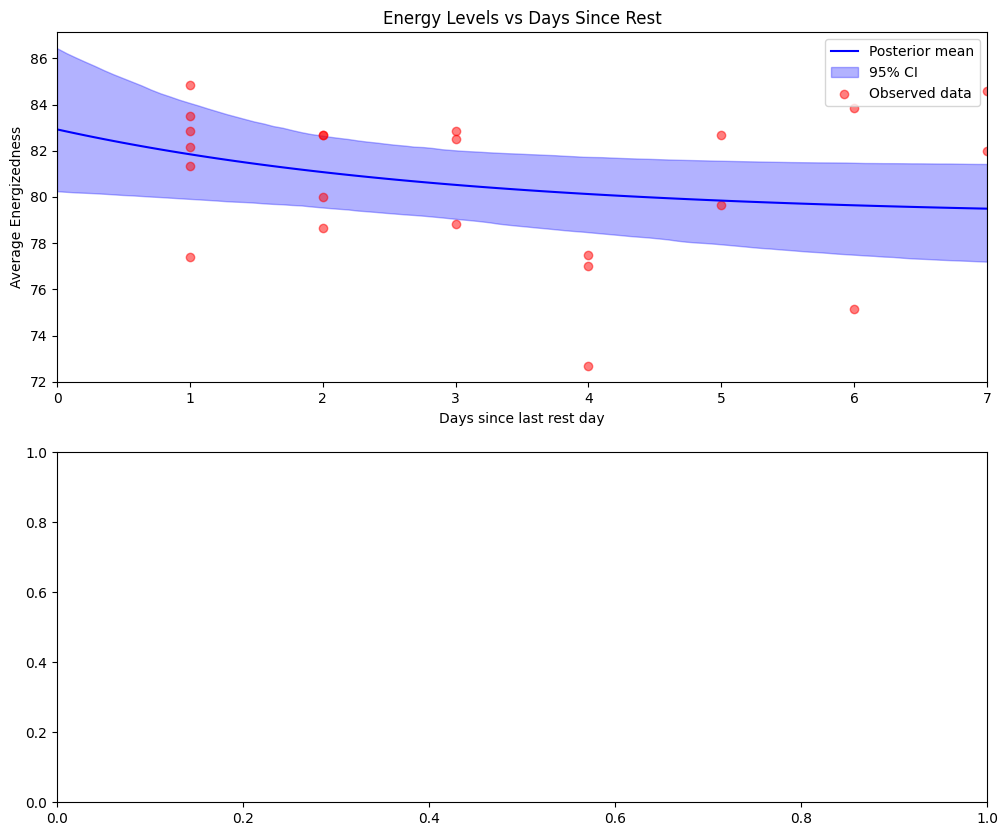

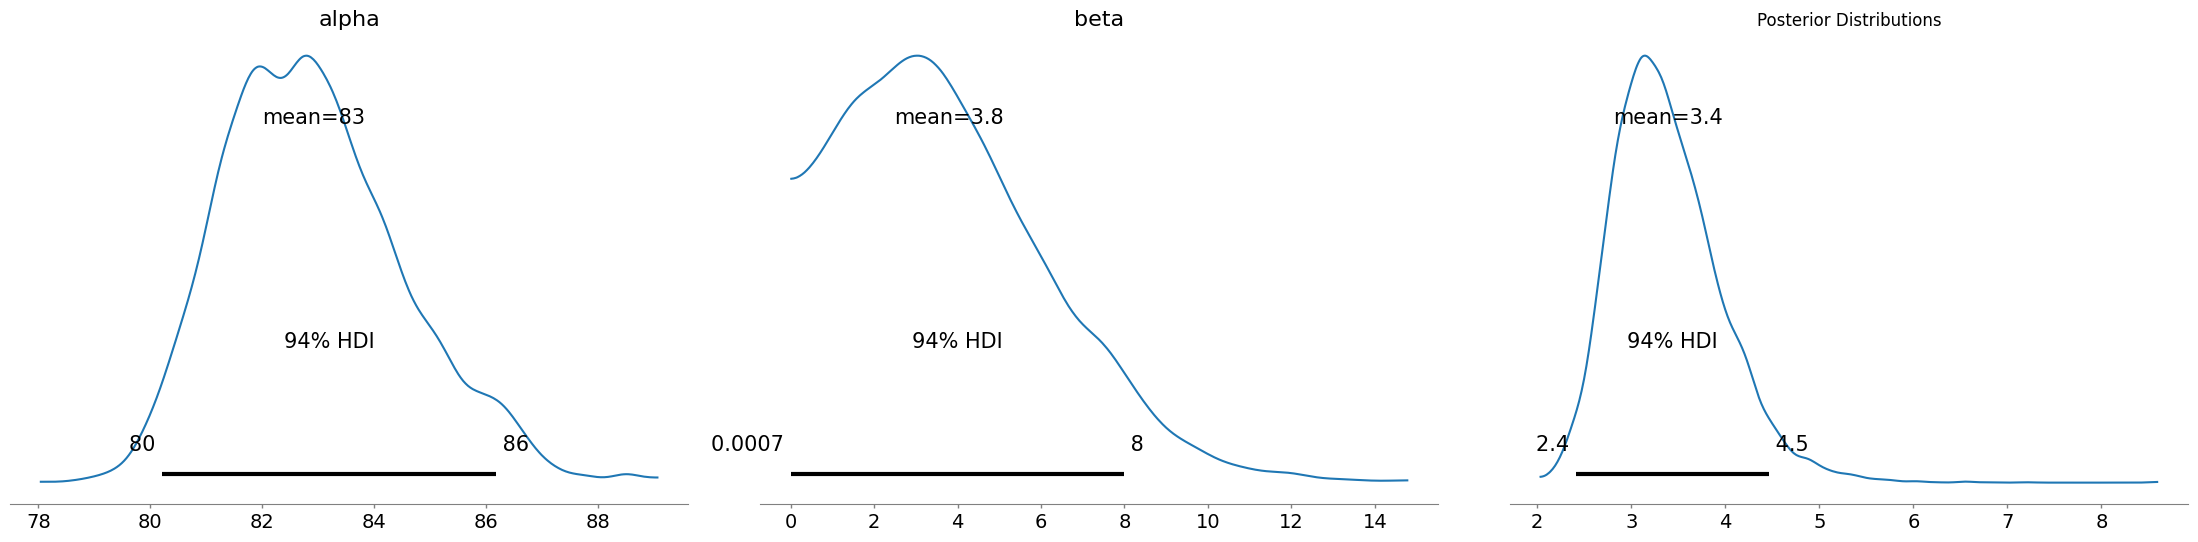

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  82.923  1.619  80.210   86.190      0.043    0.030    1614.0    1054.0   
beta    3.800  2.447   0.001    7.991      0.064    0.050    1545.0    1740.0   
sigma   3.389  0.577   2.409    4.466      0.010    0.007    3761.0    3889.0   

       r_hat  
alpha    1.0  
beta     1.0  
sigma    1.0  


In [39]:
# Plotting
plt.figure(figsize=(12, 10))

# Plot 1: Energy Levels vs Days Since Rest
plt.subplot(2, 1, 1)
x_plot = np.linspace(0, sessions['days_since_rest'].max(), 100)
alpha_samples = trace.posterior['alpha'].values.flatten()
beta_samples = trace.posterior['beta'].values.flatten()
y_post = alpha_samples[:, None] - beta_samples[:, None] * (1 - np.exp(-x_plot / 3))

plt.plot(x_plot, y_post.mean(axis=0), color='blue', label='Posterior mean')
plt.fill_between(x_plot, 
                 np.percentile(y_post, 2.5, axis=0), 
                 np.percentile(y_post, 97.5, axis=0),
                 color='blue', alpha=0.3, label='95% CI')
plt.scatter(sessions['days_since_rest'], sessions['avg_energy'], color='red', alpha=0.5, label='Observed data')
plt.xlim(0, sessions['days_since_rest'].max())  # Set appropriate x-axis limits
plt.xlabel('Days since last rest day')
plt.ylabel('Average Energizedness')
plt.title('Energy Levels vs Days Since Rest')
plt.legend()

# Plot 2: Posterior Distributions
plt.subplot(2, 1, 2)
az.plot_posterior(trace, var_names=['alpha', 'beta', 'sigma'])
plt.title('Posterior Distributions')

plt.tight_layout()
plt.show()

# Print summary statistics
print(az.summary(trace, var_names=['alpha', 'beta', 'sigma']))

/home/tassilo/repos/data_simon/.venv/lib/python3.10/site-packages/pymc/model/core.py:1366: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, y_obs_unobserved]


/home/tassilo/repos/data_simon/.venv/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.


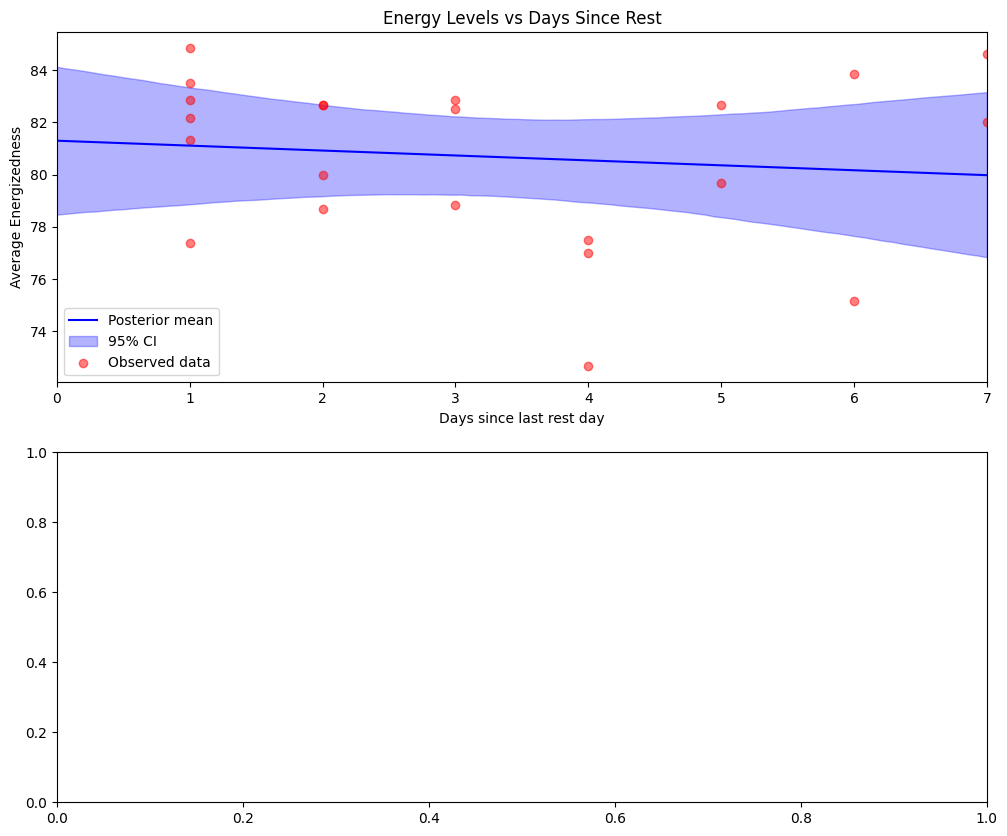

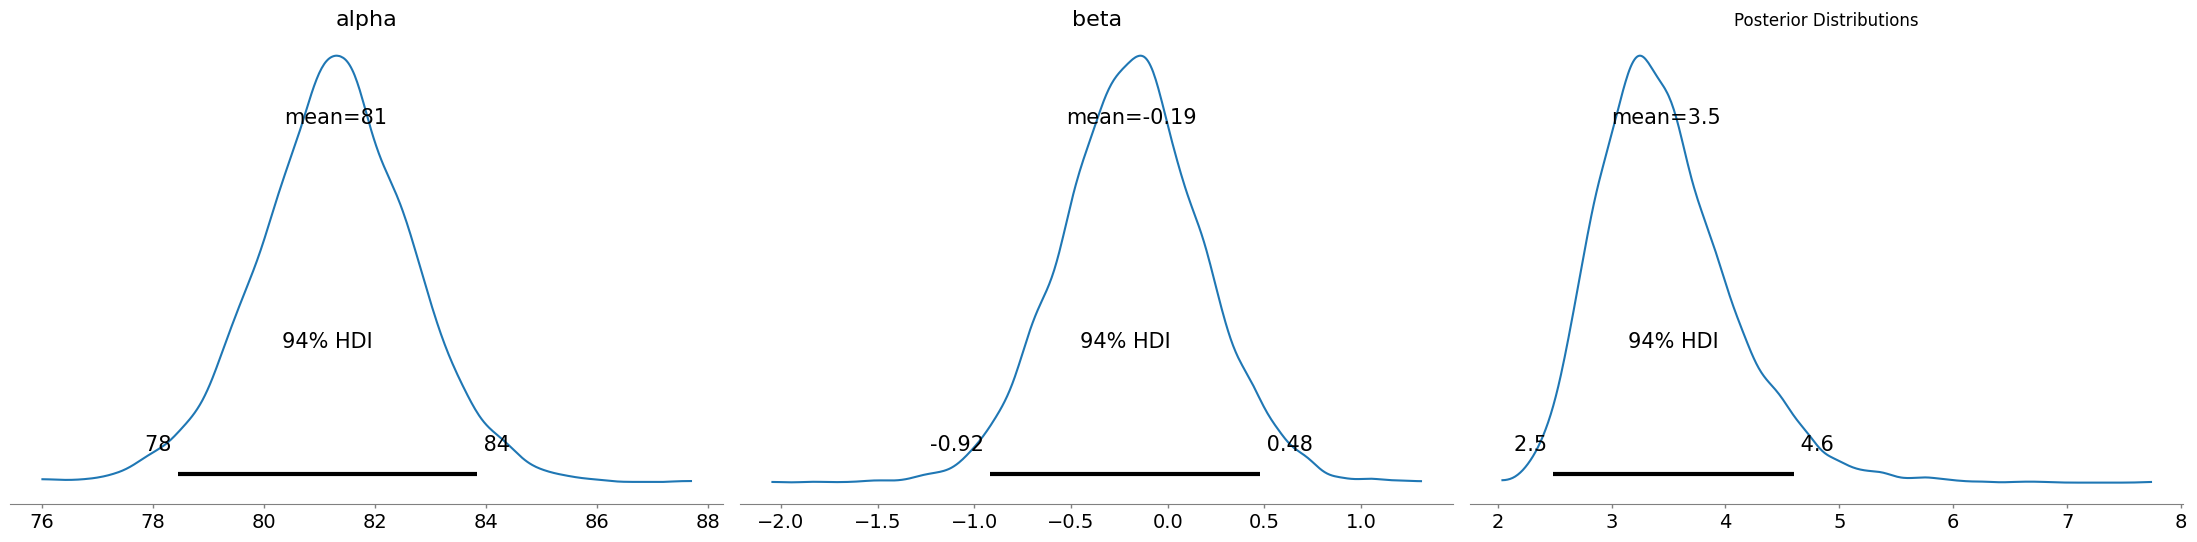

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  81.296  1.411  78.443   83.837      0.022    0.015    4332.0    4128.0   
beta   -0.188  0.372  -0.918    0.480      0.005    0.004    4625.0    4782.0   
sigma   3.475  0.593   2.490    4.602      0.008    0.006    5051.0    4551.0   

       r_hat  
alpha    1.0  
beta     1.0  
sigma    1.0  


In [40]:


# Calculate days since the last rest day correctly
sessions['days_since_rest'] = sessions['rest_day'].eq(1).cumsum()
sessions['days_since_rest'] = sessions.groupby('days_since_rest').cumcount()
sessions.days_since_rest = sessions.days_since_rest.apply(lambda x: 3 if x >= 3 else x)

# Identify energy columns
energy_columns = [col for col in sessions.columns if col.startswith('session') and sessions[col].dtype == np.float64]

# Calculate average energy for available sessions
sessions['avg_energy'] = sessions[energy_columns].mean(axis=1)

# Exclude the 0th day data
sessions = sessions[sessions['days_since_rest'] > 0]
sessions.days_since_rest = sessions.days_since_rest.apply(lambda x: 3 if x >= 3 else x)
# Bayesian linear model
with pm.Model() as model:
    # Priors
    alpha = pm.Normal('alpha', mu=80, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Expected energy level (linear model)
    mu = alpha + beta * sessions['days_since_rest']

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=sessions['avg_energy'])

    # Inference
    trace = pm.sample(2000, return_inferencedata=True)

# Plotting
plt.figure(figsize=(12, 10))

# Plot 1: Energy Levels vs Days Since Rest
plt.subplot(2, 1, 1)
x_plot = np.linspace(0, sessions['days_since_rest'].max(), 100)
alpha_samples = trace.posterior['alpha'].values.flatten()
beta_samples = trace.posterior['beta'].values.flatten()
y_post = alpha_samples[:, None] + beta_samples[:, None] * x_plot

plt.plot(x_plot, y_post.mean(axis=0), color='blue', label='Posterior mean')
plt.fill_between(x_plot, 
                 np.percentile(y_post, 2.5, axis=0), 
                 np.percentile(y_post, 97.5, axis=0),
                 color='blue', alpha=0.3, label='95% CI')
plt.scatter(sessions['days_since_rest'], sessions['avg_energy'], color='red', alpha=0.5, label='Observed data')
plt.xlim(0, sessions['days_since_rest'].max())  # Set appropriate x-axis limits
plt.xlabel('Days since last rest day')
plt.ylabel('Average Energizedness')
plt.title('Energy Levels vs Days Since Rest')
plt.legend()

# Plot 2: Posterior Distributions
plt.subplot(2, 1, 2)
az.plot_posterior(trace, var_names=['alpha', 'beta', 'sigma'])
plt.title('Posterior Distributions')

plt.tight_layout()
plt.show()

# Print summary statistics
print(az.summary(trace, var_names=['alpha', 'beta', 'sigma']))


In [34]:
# import pandas as pd
# import numpy as np
# import pymc as pm
# import arviz as az
# import matplotlib.pyplot as plt
# import seaborn as sns

# def analyze_sleep_data(data, start_date, end_date, column):
#     # Data Preparation
#     start_date = pd.to_datetime(start_date)
#     end_date = pd.to_datetime(end_date)

#     # Replace '-' with NaN and convert to datetime
#     filtered_data = data.replace('-', np.nan)
#     filtered_data = filtered_data[(filtered_data.index >= start_date) & (filtered_data.index <= end_date)]
#     filtered_data['went_to_bed'] = pd.to_datetime(filtered_data['went_to_bed'], format='%H:%M', errors='coerce')
#     filtered_data['fell_asleep'] = pd.to_datetime(filtered_data['fell_asleep'], format='%H:%M', errors='coerce')

#     # Exclude rows with missing values in 'went_to_bed' or 'fell_asleep'
#     filtered_data = filtered_data.dropna(subset=['went_to_bed', 'fell_asleep', column])

#     # Ensure positive duration to fall asleep
#     filtered_data['fell_asleep'] = filtered_data.apply(lambda row: row['fell_asleep'] + pd.Timedelta(days=1) if row['fell_asleep'] < row['went_to_bed'] else row['fell_asleep'], axis=1)

#     # Calculate the duration to fall asleep in minutes
#     filtered_data['time_to_fall_asleep'] = (filtered_data['fell_asleep'] - filtered_data['went_to_bed']).dt.total_seconds() / 60.0

#     # Calculate the total sleep duration
#     filtered_data['sleep_duration'] = filtered_data['in_bed_for'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))

#     # Normalize time to fall asleep by inverting it (lower is better, so higher inverted is better)
#     max_time_to_fall_asleep = filtered_data['time_to_fall_asleep'].max()
#     filtered_data['normalized_time_to_fall_asleep'] = max_time_to_fall_asleep + 1 - filtered_data['time_to_fall_asleep']

#     # Normalize sleep duration (assuming higher duration is better)
#     filtered_data['normalized_sleep_duration'] = filtered_data['sleep_duration']

#     # Calculate the sleep score as the average of the normalized metrics
#     filtered_data['sleep_score'] = (filtered_data['normalized_time_to_fall_asleep'] + filtered_data['normalized_sleep_duration']) / 2

#     # Plot the overall sleep scores with and without Potassium intake
#     plt.figure(figsize=(14, 6))

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_sleep_data(data, start_date, end_date, column):
    # Data Preparation
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Replace '-' with NaN and convert to datetime
    filtered_data = data.replace('-', np.nan)
    filtered_data = filtered_data[(filtered_data.index >= start_date) & (filtered_data.index <= end_date)]
    filtered_data['went_to_bed'] = pd.to_datetime(filtered_data['went_to_bed'], format='%H:%M', errors='coerce')
    filtered_data['fell_asleep'] = pd.to_datetime(filtered_data['fell_asleep'], format='%H:%M', errors='coerce')

    # Exclude rows with missing values in 'went_to_bed' or 'fell_asleep'
    filtered_data = filtered_data.dropna(subset=['went_to_bed', 'fell_asleep', column])

    # Ensure positive duration to fall asleep
    filtered_data['fell_asleep'] = filtered_data.apply(lambda row: row['fell_asleep'] + pd.Timedelta(days=1) if row['fell_asleep'] < row['went_to_bed'] else row['fell_asleep'], axis=1)

    # Calculate the duration to fall asleep in minutes
    filtered_data['time_to_fall_asleep'] = (filtered_data['fell_asleep'] - filtered_data['went_to_bed']).dt.total_seconds() / 60.0

    # Calculate the total sleep duration
    filtered_data['sleep_duration'] = filtered_data['in_bed_for'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))

    # Assign an overall sleep score (for simplicity, let's average time to fall asleep and sleep duration)
    filtered_data['sleep_score'] = (filtered_data['time_to_fall_asleep'] + filtered_data['sleep_duration']) / 2

    # Plot the overall sleep scores with and without Potassium intake
    plt.figure(figsize=(14, 6))

    # sns.histplot(filtered_data[filtered_data[column] == 1]['sleep_score'], color='blue', label=f'With {column.capitalize()}', kde=True, stat="density")
    # sns.histplot(filtered_data[filtered_data[column] == 0]['sleep_score'], color='red', label=f'Without {column.capitalize()}', kde=True, stat="density")
    plt.plot(filtered_data[filtered_data[column] == 1].index, filtered_data[filtered_data[column] == 1]['sleep_score'], 'o', color='blue', label=f'With {column.capitalize()}')
    plt.plot(filtered_data[filtered_data[column] == 0].index, filtered_data[filtered_data[column] == 0]['sleep_score'], 'o', color='red', label=f'Without {column.capitalize()}')


    # sns.histplot(filtered_data[filtered_data[column] == 1]['sleep_score'], color='blue', label=f'With {column.capitalize()}', kde=True, stat="density")
    # sns.histplot(filtered_data[filtered_data[column] == 0]['sleep_score'], color='red', label=f'Without {column.capitalize()}', kde=True, stat="density")
    plt.title('Overall Sleep Score')
    plt.xlabel('Date')
    plt.ylabel('Standardized Sleep Disturbance Score')
    plt.legend()
    plt.tight_layout()
    plt.show()

#     # Bayesian Model: Overall Sleep Score
#     with pm.Model() as model_sleep_score:
#         # Priors for each group
#         mu1_sleep_score = pm.Normal('mu1_sleep_score', mu=0, sigma=10)
#         mu2_sleep_score = pm.Normal('mu2_sleep_score', mu=0, sigma=10)
#         sigma1_sleep_score = pm.HalfNormal('sigma1_sleep_score', sigma=10)
#         sigma2_sleep_score = pm.HalfNormal('sigma2_sleep_score', sigma=10)

#         # Group likelihoods
#         group1_sleep_score = pm.Normal('group1_sleep_score', mu=mu1_sleep_score, sigma=sigma1_sleep_score, observed=filtered_data['sleep_score'][filtered_data[column] == 0])
#         group2_sleep_score = pm.Normal('group2_sleep_score', mu=mu2_sleep_score, sigma=sigma2_sleep_score, observed=filtered_data['sleep_score'][filtered_data[column] == 1])

#         # Difference in means
#         diff_sleep_score = pm.Deterministic('diff_sleep_score', mu2_sleep_score - mu1_sleep_score)

#         # Inference
#         trace_sleep_score = pm.sample(2000, return_inferencedata=True)

#     # Summary of the results
#     print("Summary for Overall Sleep Score Model:")
#     print(az.summary(trace_sleep_score, var_names=['mu1_sleep_score', 'mu2_sleep_score', 'sigma1_sleep_score', 'sigma2_sleep_score', 'diff_sleep_score']))

#     # Plot the results
#     az.plot_trace(trace_sleep_score)
#     plt.show()

#     # Plot the posterior distributions of the differences
#     az.plot_posterior(trace_sleep_score, var_names=['diff_sleep_score'])
#     plt.title('Posterior Distribution of Difference in Overall Sleep Score')
#     plt.show()

#     az.plot_loo_pit

# # Example usage:
# # analyze_sleep_data(data, '2024-05-28', '2024-06-13', 'potassium')
#     plt.title('Overall Sleep Score')
#     plt.xlabel('Sleep Score')
#     plt.ylabel('Density')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

#     # Scatter plot of the normalized sleep data
#     plt.figure(figsize=(14, 6))
#     plt.scatter(range(len(filtered_data[filtered_data[column] == 1])), filtered_data[filtered_data[column] == 1]['sleep_score'], color='blue', label=f'With {column.capitalize()}')
#     plt.scatter(range(len(filtered_data[filtered_data[column] == 0])), filtered_data[filtered_data[column] == 0]['sleep_score'], color='red', label=f'Without {column.capitalize()}')
#     plt.title('Normalized Sleep Data')
#     plt.xlabel('nth')
#     plt.ylabel('Standardized Sleep Disturbance Score')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

#     # Bayesian Model: Overall Sleep Score
#     with pm.Model() as model_sleep_score:
#         # Priors for each group
#         mu1_sleep_score = pm.Normal('mu1_sleep_score', mu=0, sigma=10)
#         mu2_sleep_score = pm.Normal('mu2_sleep_score', mu=0, sigma=10)
#         sigma1_sleep_score = pm.HalfNormal('sigma1_sleep_score', sigma=10)
#         sigma2_sleep_score = pm.HalfNormal('sigma2_sleep_score', sigma=10)

#         # Group likelihoods
#         group1_sleep_score = pm.Normal('group1_sleep_score', mu=mu1_sleep_score, sigma=sigma1_sleep_score, observed=filtered_data['sleep_score'][filtered_data[column] == 0])
#         group2_sleep_score = pm.Normal('group2_sleep_score', mu=mu2_sleep_score, sigma=sigma2_sleep_score, observed=filtered_data['sleep_score'][filtered_data[column] == 1])

#         # Difference in means
#         diff_sleep_score = pm.Deterministic('diff_sleep_score', mu2_sleep_score - mu1_sleep_score)

#         # Inference
#         trace_sleep_score = pm.sample(2000, return_inferencedata=True)

#     # Summary of the results
#     print("Summary for Overall Sleep Score Model:")
#     print(az.summary(trace_sleep_score, var_names=['mu1_sleep_score', 'mu2_sleep_score', 'sigma1_sleep_score', 'sigma2_sleep_score', 'diff_sleep_score']))

#     # Plot the results
#     az.plot_trace(trace_sleep_score)
#     plt.show()

#     # Plot the posterior distributions of the differences
#     az.plot_posterior(trace_sleep_score, var_names=['diff_sleep_score'])
#     plt.title('Posterior Distribution of Difference in Overall Sleep Score')
#     plt.show()

# Example usage:
# analyze_sleep_data(data, '2024-05-28', '2024-06-13', 'potassium')



In [70]:
sessions = data[session_columns]
sessions = sessions[sessions.index > start_date]

# Calculate days since the last rest day correctly
sessions['days_since_rest'] = sessions['rest_day'].eq(1).cumsum()
sessions['days_since_rest'] = sessions.groupby('days_since_rest').cumcount()
sessions['days_since_rest'] = sessions['days_since_rest'].apply(lambda x: 3 if x >= 3 else x)

# Calculate days until the next rest day
sessions['days_until_rest'] = sessions[::-1]['rest_day'].eq(1).cumsum()
sessions['days_until_rest'] = sessions.groupby('days_until_rest').cumcount()
# sessions['days_until_rest'] = sessions['days_until_rest'].apply(lambda x: 3 if x >= 3 else x)

# Identify energy columns
energy_columns = [col for col in sessions.columns if col.startswith('session') and sessions[col].dtype == np.float64]

# Calculate average energy for available sessions
sessions['avg_energy'] = sessions[energy_columns].mean(axis=1)

# Exclude the 0th day data
sessions_until_rest = sessions[sessions['days_until_rest'] > 0]


In [71]:
analyze_energy_levels_correlation(sessions, 'days_util_rest', 'avg_energy', 'rest_day')

NameError: name 'analyze_energy_levels_correlation' is not defined

In [36]:

# Calculate days since the last rest day correctly
sessions['days_since_rest'] = sessions['rest_day'].eq(1).cumsum()
sessions['days_since_rest'] = sessions.groupby('days_since_rest').cumcount()
sessions.days_since_rest = sessions.days_since_rest.apply(lambda x: 3 if x >= 3 else x)

# Identify energy columns
energy_columns = [col for col in sessions.columns if col.startswith('session') and sessions[col].dtype == np.float64]

# Calculate average energy for available sessions
sessions['avg_energy'] = sessions[energy_columns].mean(axis=1)

# Exclude the 0th day data
sessions = sessions[sessions['days_since_rest'] > 0]

In [39]:
data.columns

Index(['date', 'went_to_bed', 'fell_asleep', 'in_bed_for', 'woke_up',
       'standup', 'weekday', 'Potassium (1) (10% prob)',
       'Iodine (1) (50% prob)', 'Omega3 (1) (70% prob)',
       'Vitamin D (1) (70% prob)', 'Vitamin B complex (30% prob)',
       'Magnesium (50%)', 'Probiotic pills', 'notes', 'creatine',
       'Masturbate (before sleep)', 'Masturbate (time)', 'porn', 'earplugs',
       'window', 'melatonin', 'Übelkeit', 'last_food', 'l_theanine',
       'methylphenidate', 'muntermacher', 'caffeine', 'Unnamed: 28',
       'session_1_cold_shower', 'session_2_cold_shower', 'session_3',
       'rest_day', 'session_1_1', 'session_1_2', 'session_1_3', 'session_2_1',
       'session_2_2', 'session_2_3', 'session_3_1', 'session_3_2',
       'session_3_3'],
      dtype='object')

In [37]:
analyze_sleep_data(data, '2024-05-28', '2024-06-13', 'potassium')

KeyError: ['potassium']

In [25]:
analyze_sleep_data(data, '2024-05-28', '2024-06-28', 'omega3')

KeyError: ['omega3']

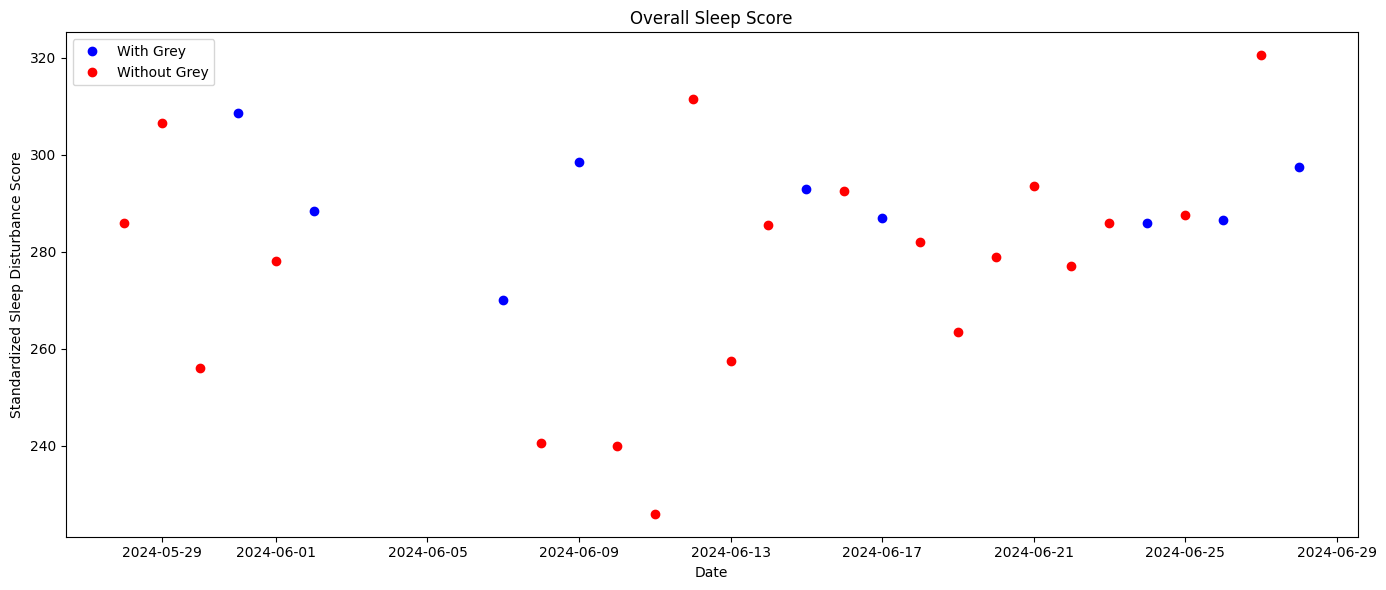

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu1_sleep_score, mu2_sleep_score, sigma1_sleep_score, sigma2_sleep_score]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


Summary for Overall Sleep Score Model:
                      mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu1_sleep_score     47.558   9.985  29.124   66.423      0.115    0.082   
mu2_sleep_score     31.620  10.033  13.322   51.411      0.109    0.078   
sigma1_sleep_score  96.090   5.335  86.067  106.259      0.061    0.043   
sigma2_sleep_score  86.125   5.155  76.842   96.283      0.057    0.040   
diff_sleep_score   -15.939  14.255 -41.787   11.774      0.160    0.124   

                    ess_bulk  ess_tail  r_hat  
mu1_sleep_score       7495.0    6876.0    1.0  
mu2_sleep_score       8394.0    6582.0    1.0  
sigma1_sleep_score    7695.0    6256.0    1.0  
sigma2_sleep_score    8227.0    6782.0    1.0  
diff_sleep_score      7917.0    6546.0    1.0  


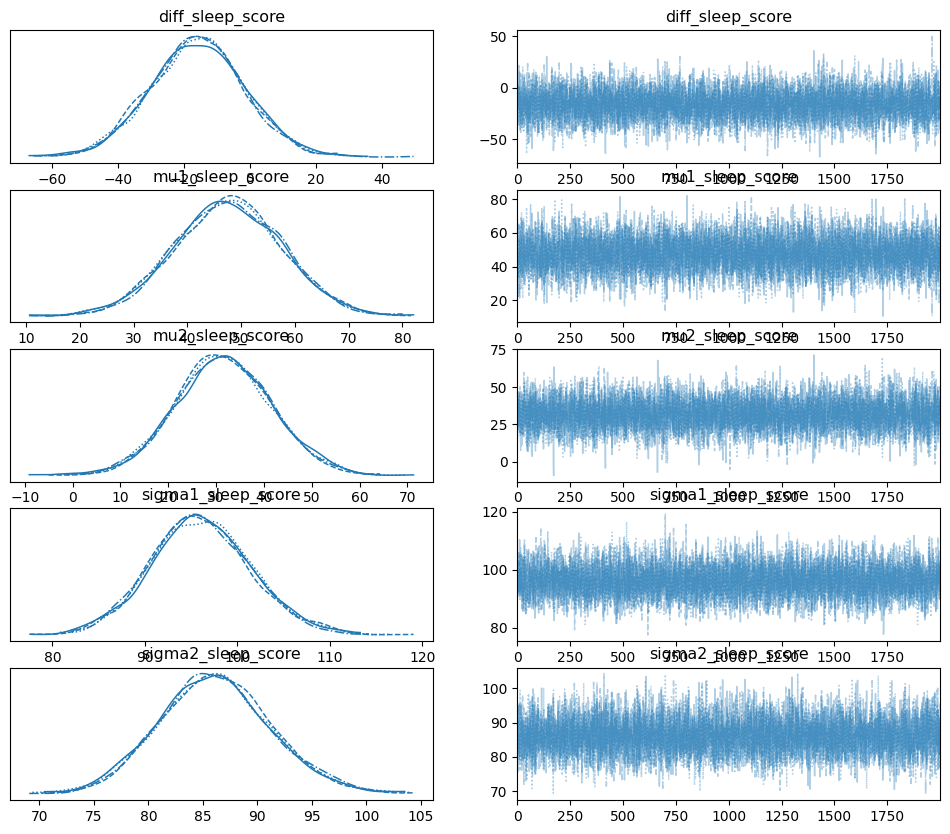

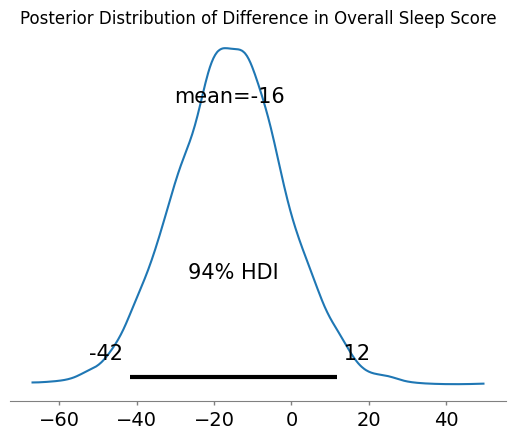

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


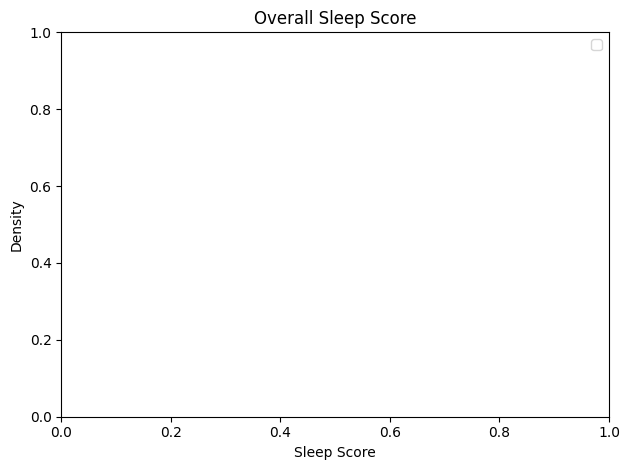

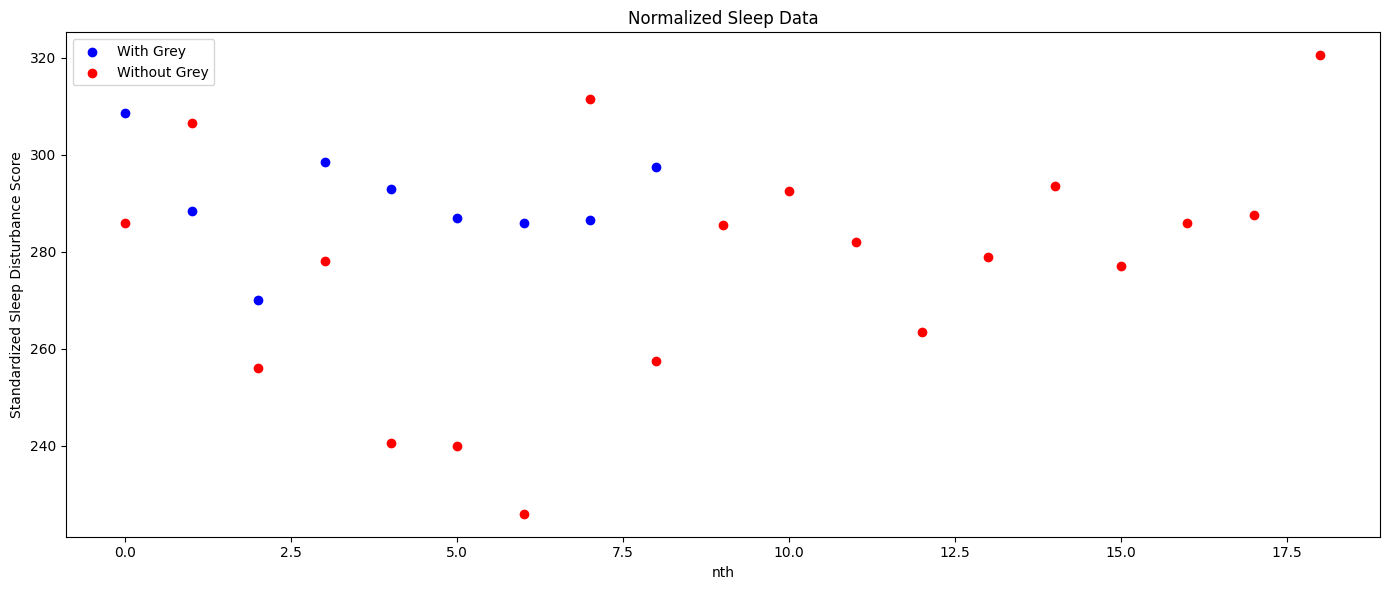

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu1_sleep_score, mu2_sleep_score, sigma1_sleep_score, sigma2_sleep_score]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


Summary for Overall Sleep Score Model:
                      mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu1_sleep_score     47.680  10.159  28.122   66.376      0.110    0.078   
mu2_sleep_score     31.822  10.168  12.455   50.649      0.114    0.081   
sigma1_sleep_score  96.001   5.138  86.033  105.280      0.057    0.040   
sigma2_sleep_score  86.056   5.264  76.060   95.978      0.067    0.047   
diff_sleep_score   -15.858  14.424 -43.040   10.678      0.160    0.126   

                    ess_bulk  ess_tail  r_hat  
mu1_sleep_score       8532.0    7168.0    1.0  
mu2_sleep_score       7913.0    6916.0    1.0  
sigma1_sleep_score    8133.0    6922.0    1.0  
sigma2_sleep_score    6276.0    6080.0    1.0  
diff_sleep_score      8191.0    6250.0    1.0  


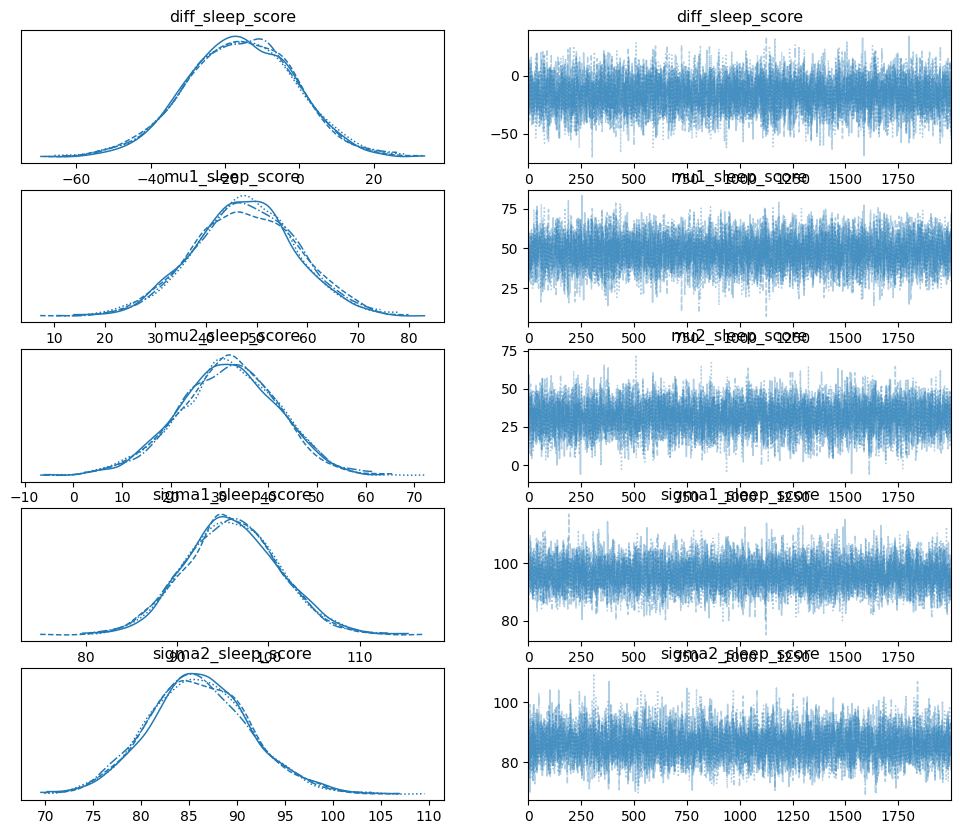

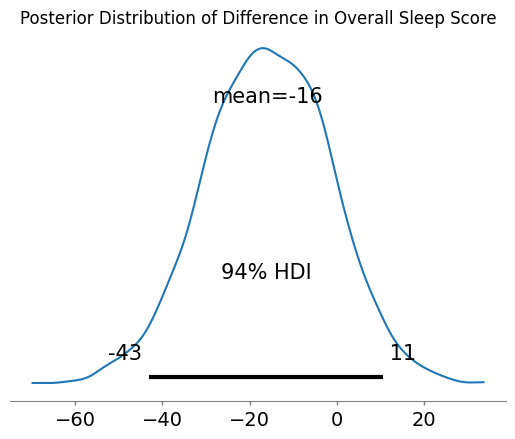

In [24]:
analyze_sleep_data(data, '2024-05-28', '2024-06-28', 'grey')

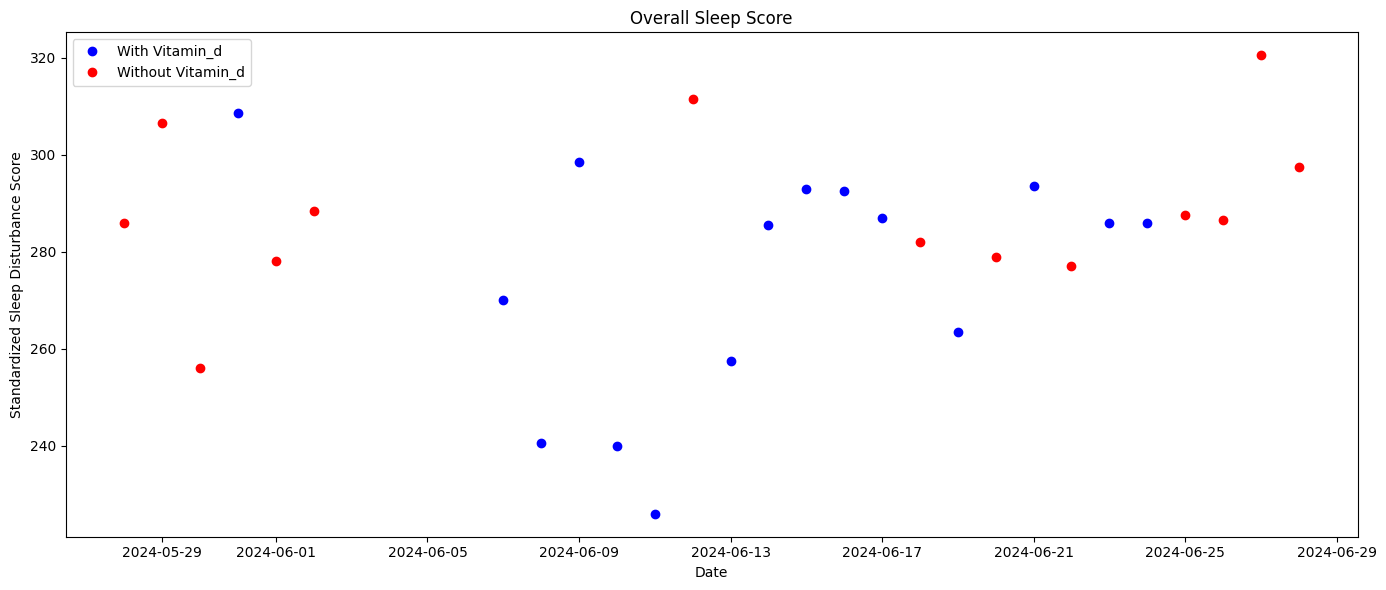

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu1_sleep_score, mu2_sleep_score, sigma1_sleep_score, sigma2_sleep_score]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


Summary for Overall Sleep Score Model:
                      mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu1_sleep_score     38.567   9.998  20.382   57.507      0.111    0.080   
mu2_sleep_score     41.874  10.189  22.672   60.704      0.113    0.081   
sigma1_sleep_score  92.226   5.183  82.344  101.809      0.056    0.040   
sigma2_sleep_score  91.806   5.352  81.397  101.370      0.064    0.045   
diff_sleep_score     3.307  14.306 -23.524   30.024      0.156    0.142   

                    ess_bulk  ess_tail  r_hat  
mu1_sleep_score       8089.0    6462.0    1.0  
mu2_sleep_score       8098.0    6639.0    1.0  
sigma1_sleep_score    8604.0    6942.0    1.0  
sigma2_sleep_score    7004.0    5257.0    1.0  
diff_sleep_score      8369.0    6438.0    1.0  


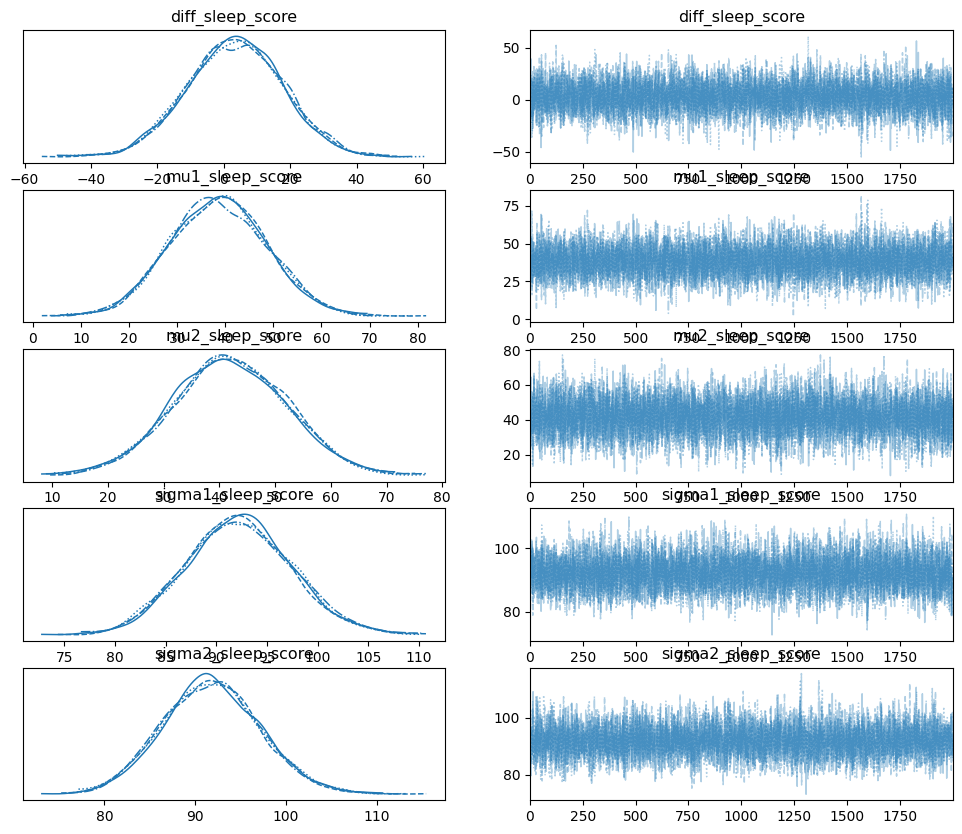

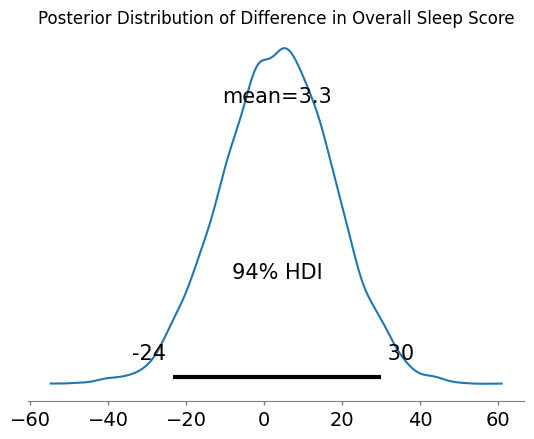

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


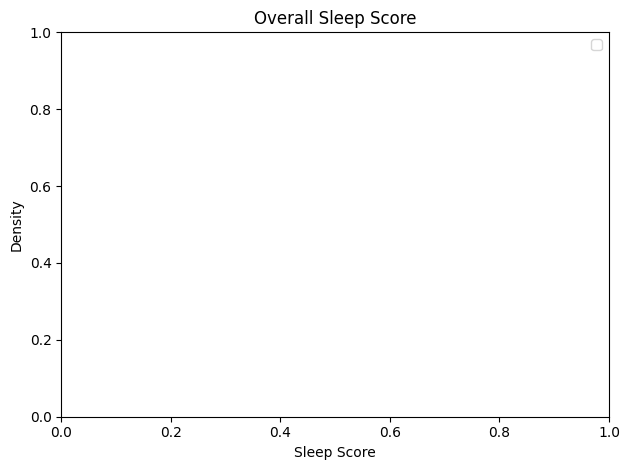

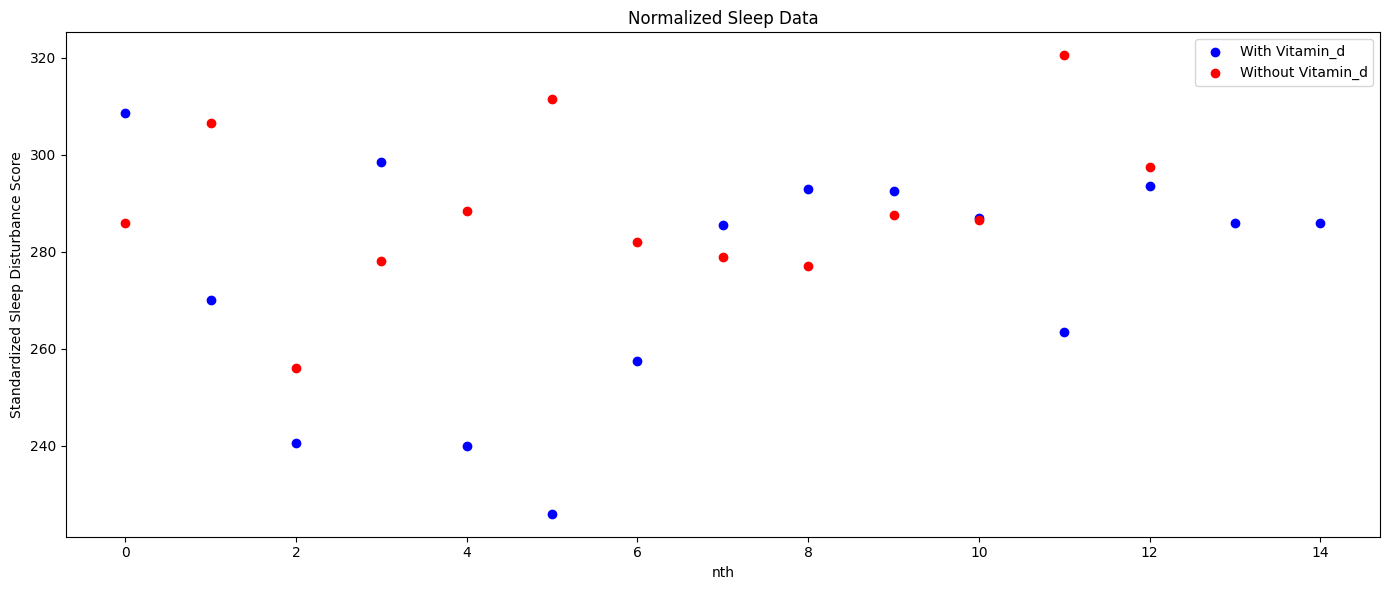

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu1_sleep_score, mu2_sleep_score, sigma1_sleep_score, sigma2_sleep_score]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


Summary for Overall Sleep Score Model:
                      mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu1_sleep_score     38.387  10.131  19.473   57.479      0.112    0.080   
mu2_sleep_score     41.632   9.961  23.175   60.443      0.115    0.081   
sigma1_sleep_score  92.240   5.201  82.839  102.354      0.060    0.042   
sigma2_sleep_score  91.943   5.164  81.843  101.399      0.060    0.043   
diff_sleep_score     3.245  14.154 -23.099   29.810      0.158    0.138   

                    ess_bulk  ess_tail  r_hat  
mu1_sleep_score       8132.0    6790.0    1.0  
mu2_sleep_score       7517.0    6183.0    1.0  
sigma1_sleep_score    7549.0    6351.0    1.0  
sigma2_sleep_score    7338.0    6431.0    1.0  
diff_sleep_score      8023.0    6635.0    1.0  


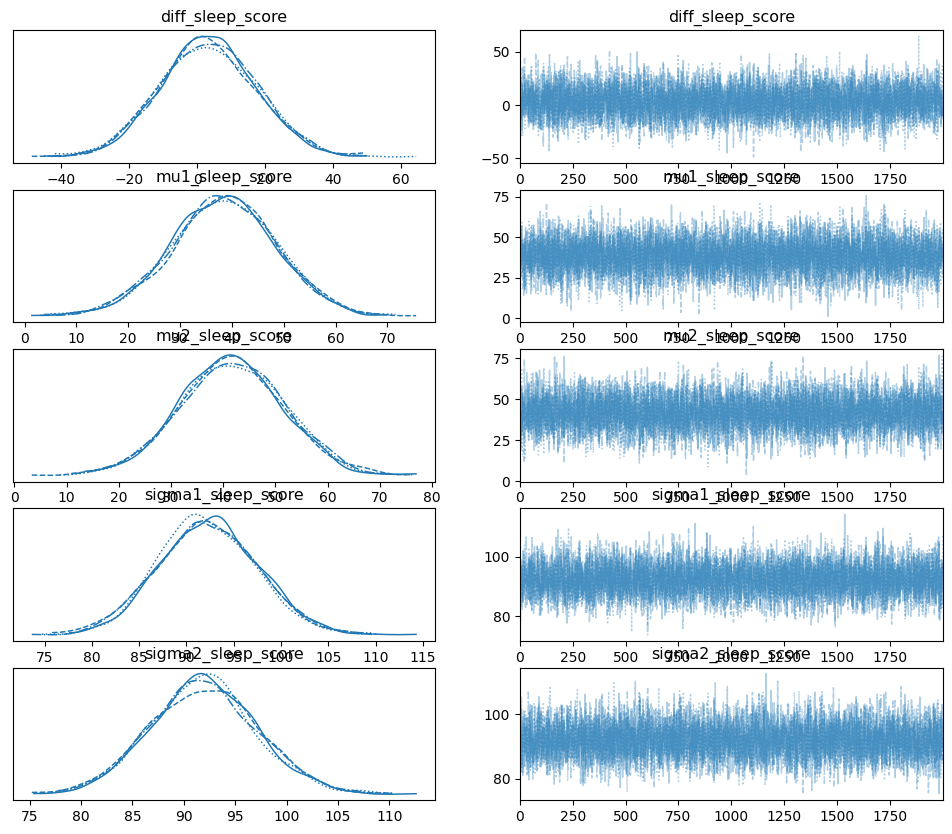

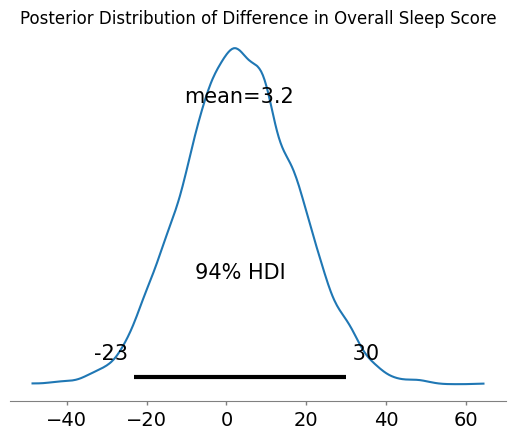

In [25]:
analyze_sleep_data(data, '2024-05-28', '2024-06-28', 'vitamin_d')

In [71]:
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

filtered_data = data
# Filter data based on dates
filtered_data = filtered_data[(filtered_data.index >= start_date) & (filtered_data.index <= end_date)]

# Exclude days with all missing energy data for the first two sessions
filtered_data = filtered_data.dropna(subset=['session_1_1', 'session_1_2', 'session_2_1', 'session_2_2'], how='all')

filtered_data

date         went_to_bed         fell_asleep in_bed_for  \
Date                                                                       
2024-05-29 2024-05-29 1900-01-01 21:50:00 1900-01-01 22:43:00      09:20   
2024-05-30 2024-05-30 1900-01-01 22:30:00 1900-01-01 23:02:00      08:00   
2024-06-01 2024-06-01 1900-01-01 22:08:00 1900-01-01 22:48:00      08:36   
2024-06-02 2024-06-02 1900-01-01 21:56:00 1900-01-01 22:45:00      08:48   
2024-06-07 2024-06-07 1900-01-01 23:10:00 1900-01-02 00:04:00      08:06   
2024-06-08 2024-06-08 1900-01-01 22:06:00 1900-01-01 22:27:00      07:40   
2024-06-09 2024-06-09 1900-01-01 21:53:00 1900-01-01 22:45:00      09:05   
2024-06-10 2024-06-10 1900-01-01 23:10:00 1900-01-01 23:25:00      07:45   
2024-06-12 2024-06-12 1900-01-01 22:15:00 1900-01-01 22:50:00      09:48   
2024-06-13 2024-06-13 1900-01-01 23:05:00 1900-01-01 23:43:00      07:57   

           woke_up standup  potassium  grey  omega3  vitamin_d  ...  \
Date                                                            ...   
2024-05-29   08:05   08:07        0.0   0.0     1.0        0.0  ...   
2024-05-30   07:12   07:30        0.0   0.0     0.0        0.0  ...   
2024-06-01   07:24   07:27        0.0   0.0     0.0        0.0  ...   
2024-06-02   07:39   07:41        1.0   1.0     1.0        0.0  ...   
2024-06-07   08:10   08:12        1.0   1.0     0.0        1.0  ...   
2024-06-08   07:33   07:38        1.0   0.0     1.0        1.0  ...   
2024-06-09   07:51   07:53        1.0   1.0     1.0        1.0  ...   
2024-06-10   07:10   08:09        1.0   0.0     1.0        1.0  ...   
2024-06-12   08:40   08:42        0.0   0.0     0.0        0.0  ...   
2024-06-13   07:40   09:14        0.0   0.0     1.0        1.0  ...   

           session_1_3 session_2_1  session_2_2  session_2_3 session_3_1  \
Date                                                                       
2024-05-29        76.0        84.0         85.0         76.0        79.0   
2024-05-30        85.0        82.0         84.0         89.0         NaN   
2024-06-01        80.0        79.0         77.0         82.0        82.0   
2024-06-02        75.0        77.0         75.0         76.0         NaN   
2024-06-07         NaN        82.0         81.0         79.0        75.0   
2024-06-08        69.0        82.0         79.0         80.0        78.0   
2024-06-09        81.0        85.0         84.0         84.0         NaN   
2024-06-10        70.0        78.0         76.0         71.0        78.0   
2024-06-12        71.0        75.0         76.0         73.0        77.0   
2024-06-13         NaN        86.0         85.0         84.0        76.0   

           session_3_2 session_3_3 time_to_fall_asleep  sleep_duration  \
Date                                                                     
2024-05-29        75.0        68.0                53.0             560   
2024-05-30         NaN         NaN                32.0             480   
2024-06-01        82.0        81.0                40.0             516   
2024-06-02         NaN         NaN                49.0             528   
2024-06-07        76.0        70.0             -1386.0             486   
2024-06-08        78.0        69.0                21.0             460   
2024-06-09         NaN         NaN                52.0             545   
2024-06-10        74.0         NaN                15.0             465   
2024-06-12        71.0        73.0                35.0             588   
2024-06-13        77.0        78.0                38.0             477   

            sleep_score  
Date                     
2024-05-29        306.5  
2024-05-30        256.0  
2024-06-01        278.0  
2024-06-02        288.5  
2024-06-07       -450.0  
2024-06-08        240.5  
2024-06-09        298.5  
2024-06-10        240.0  
2024-06-12        311.5  
2024-06-13        257.5  

[10 rows x 38 columns]

In [72]:
# Calculate the average energy levels for the first two work sessions
filtered_data['avg_energy_session_1'] = filtered_data[['session_1_1', 'session_1_2']].mean(axis=1, skipna=True)
filtered_data['avg_energy_session_2'] = filtered_data[['session_2_1', 'session_2_2']].mean(axis=1, skipna=True)
filtered_data['avg_energy'] = filtered_data[['avg_energy_session_1', 'avg_energy_session_2']].mean(axis=1, skipna=True)

# Drop rows where 'avg_energy' is NaN (if both sessions are missing)
filtered_data = filtered_data.dropna(subset=['avg_energy'])

filtered_data


date         went_to_bed         fell_asleep in_bed_for  \
Date                                                                       
2024-05-29 2024-05-29 1900-01-01 21:50:00 1900-01-01 22:43:00      09:20   
2024-05-30 2024-05-30 1900-01-01 22:30:00 1900-01-01 23:02:00      08:00   
2024-06-01 2024-06-01 1900-01-01 22:08:00 1900-01-01 22:48:00      08:36   
2024-06-02 2024-06-02 1900-01-01 21:56:00 1900-01-01 22:45:00      08:48   
2024-06-07 2024-06-07 1900-01-01 23:10:00 1900-01-02 00:04:00      08:06   
2024-06-08 2024-06-08 1900-01-01 22:06:00 1900-01-01 22:27:00      07:40   
2024-06-09 2024-06-09 1900-01-01 21:53:00 1900-01-01 22:45:00      09:05   
2024-06-10 2024-06-10 1900-01-01 23:10:00 1900-01-01 23:25:00      07:45   
2024-06-12 2024-06-12 1900-01-01 22:15:00 1900-01-01 22:50:00      09:48   
2024-06-13 2024-06-13 1900-01-01 23:05:00 1900-01-01 23:43:00      07:57   

           woke_up standup  potassium  grey  omega3  vitamin_d  ...  \
Date                                                            ...   
2024-05-29   08:05   08:07        0.0   0.0     1.0        0.0  ...   
2024-05-30   07:12   07:30        0.0   0.0     0.0        0.0  ...   
2024-06-01   07:24   07:27        0.0   0.0     0.0        0.0  ...   
2024-06-02   07:39   07:41        1.0   1.0     1.0        0.0  ...   
2024-06-07   08:10   08:12        1.0   1.0     0.0        1.0  ...   
2024-06-08   07:33   07:38        1.0   0.0     1.0        1.0  ...   
2024-06-09   07:51   07:53        1.0   1.0     1.0        1.0  ...   
2024-06-10   07:10   08:09        1.0   0.0     1.0        1.0  ...   
2024-06-12   08:40   08:42        0.0   0.0     0.0        0.0  ...   
2024-06-13   07:40   09:14        0.0   0.0     1.0        1.0  ...   

           session_2_3 session_3_1  session_3_2  session_3_3  \
Date                                                           
2024-05-29        76.0        79.0         75.0         68.0   
2024-05-30        89.0         NaN          NaN          NaN   
2024-06-01        82.0        82.0         82.0         81.0   
2024-06-02        76.0         NaN          NaN          NaN   
2024-06-07        79.0        75.0         76.0         70.0   
2024-06-08        80.0        78.0         78.0         69.0   
2024-06-09        84.0         NaN          NaN          NaN   
2024-06-10        71.0        78.0         74.0          NaN   
2024-06-12        73.0        77.0         71.0         73.0   
2024-06-13        84.0        76.0         77.0         78.0   

           time_to_fall_asleep sleep_duration sleep_score  \
Date                                                        
2024-05-29                53.0            560       306.5   
2024-05-30                32.0            480       256.0   
2024-06-01                40.0            516       278.0   
2024-06-02                49.0            528       288.5   
2024-06-07             -1386.0            486      -450.0   
2024-06-08                21.0            460       240.5   
2024-06-09                52.0            545       298.5   
2024-06-10                15.0            465       240.0   
2024-06-12                35.0            588       311.5   
2024-06-13                38.0            477       257.5   

           avg_energy_session_1  avg_energy_session_2  avg_energy  
Date                                                               
2024-05-29                 73.5                  84.5       79.00  
2024-05-30                 84.5                  83.0       83.75  
2024-06-01                 77.5                  78.0       77.75  
2024-06-02                 81.0                  76.0       78.50  
2024-06-07                 72.5                  81.5       77.00  
2024-06-08                 81.0                  80.5       80.75  
2024-06-09                 80.5                  84.5       82.50  
2024-06-10                 70.5                  77.0       73.75  
2024-06-12                 78.0                  75.5       76.75  
2

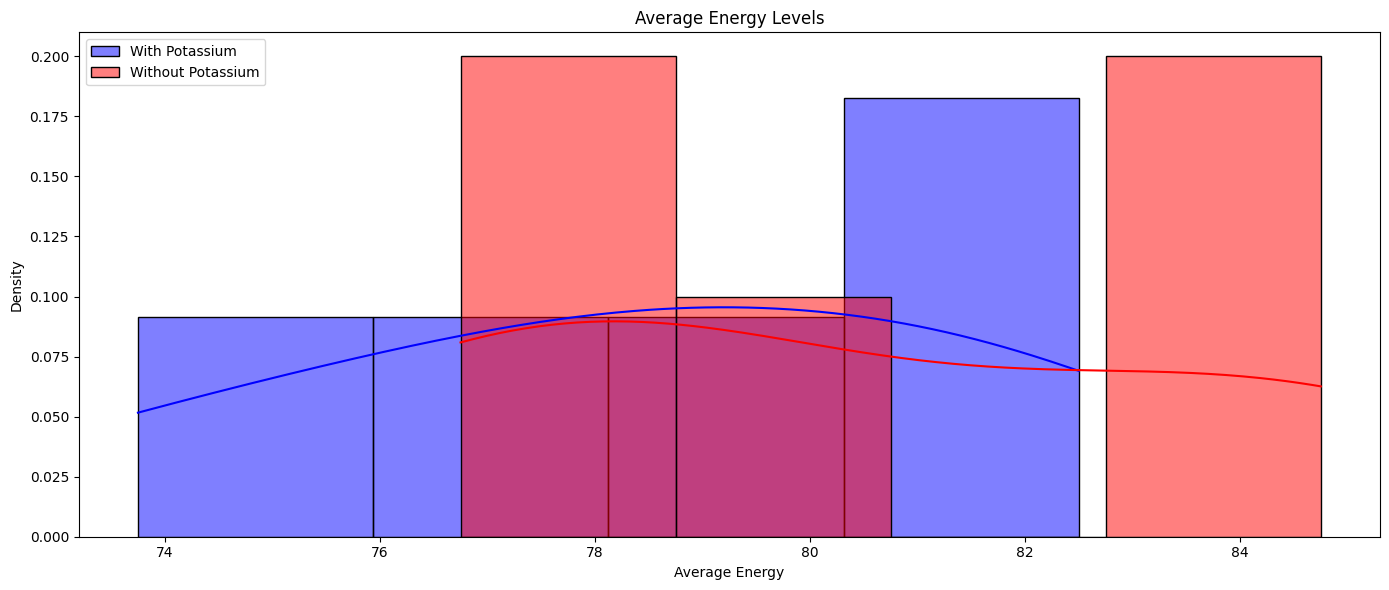

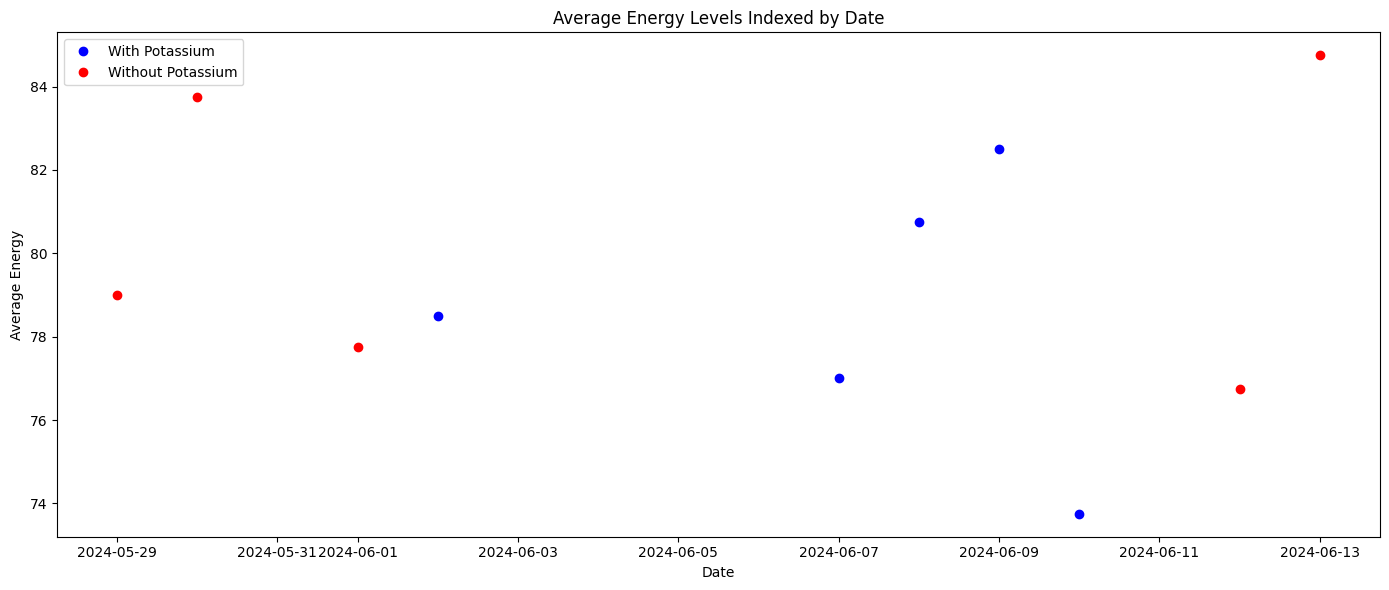

In [74]:

column = 'potassium'
# Plot the average energy levels with and without the given column (e.g., Potassium) intake
plt.figure(figsize=(14, 6))
sns.histplot(filtered_data[filtered_data[column] == 1]['avg_energy'], color='blue', label=f'With {column.capitalize()}', kde=True, stat="density")
sns.histplot(filtered_data[filtered_data[column] == 0]['avg_energy'], color='red', label=f'Without {column.capitalize()}', kde=True, stat="density")
plt.title('Average Energy Levels')
plt.xlabel('Average Energy')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# Scatter plot of the energy levels indexed by date
plt.figure(figsize=(14, 6))
plt.plot(filtered_data[filtered_data[column] == 1].index, filtered_data[filtered_data[column] == 1]['avg_energy'], 'o', color='blue', label=f'With {column.capitalize()}')
plt.plot(filtered_data[filtered_data[column] == 0].index, filtered_data[filtered_data[column] == 0]['avg_energy'], 'o', color='red', label=f'Without {column.capitalize()}')
plt.title('Average Energy Levels Indexed by Date')
plt.xlabel('Date')
plt.ylabel('Average Energy')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

def analyze_energy_levels(data, start_date, end_date, column):
    # Data Preparation
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Filter data based on dates
    filtered_data = data.replace('-', np.nan)
    filtered_data = filtered_data[(filtered_data.index >= start_date) & (filtered_data.index <= end_date)]

    # Exclude days with all missing energy data for the first two sessions
    filtered_data = filtered_data.dropna(subset=['session_1_1', 'session_1_2', 'session_2_1', 'session_2_2'], how='all')

    # Calculate the average energy levels for the first two work sessions
    filtered_data['avg_energy_session_1'] = filtered_data[['session_1_1', 'session_1_2']].mean(axis=1, skipna=True)
    filtered_data['avg_energy_session_2'] = filtered_data[['session_2_1', 'session_2_2']].mean(axis=1, skipna=True)
    filtered_data['avg_energy'] = filtered_data[['avg_energy_session_1', 'avg_energy_session_2']].mean(axis=1, skipna=True)

    # Drop rows where 'avg_energy' is NaN (if both sessions are missing)
    filtered_data = filtered_data.dropna(subset=['avg_energy'])

    # Plot the average energy levels with different values of the specified column
    plt.figure(figsize=(14, 6))
    unique_values = filtered_data[column].dropna().unique()
    for value in unique_values:
        sns.histplot(filtered_data[filtered_data[column] == value]['avg_energy'], kde=True, stat="density", label=f'{column.capitalize()} = {value}')
    plt.title('Average Energy Levels')
    plt.xlabel('Average Energy')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Scatter plot of the energy levels indexed by date
    plt.figure(figsize=(14, 6))
    for value in unique_values:
        plt.plot(filtered_data[filtered_data[column] == value].index, filtered_data[filtered_data[column] == value]['avg_energy'], 'o', label=f'{column.capitalize()} = {value}')
    plt.title('Average Energy Levels Indexed by Date')
    plt.xlabel('Date')
    plt.ylabel('Average Energy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Bayesian Model: Average Energy Levels
    with pm.Model() as model_energy_levels:
        # Priors for each unique value of the column
        priors = {}
        likelihoods = []
        for value in unique_values:
            priors[f'mu_{value}'] = pm.Normal(f'mu_{value}', mu=0, sigma=10)
            priors[f'sigma_{value}'] = pm.HalfNormal(f'sigma_{value}', sigma=10)
            likelihoods.append(pm.Normal(f'energy_{value}', mu=priors[f'mu_{value}'], sigma=priors[f'sigma_{value}'], observed=filtered_data['avg_energy'][filtered_data[column] == value]))

        # Difference in means
        differences = {}
        for i in range(len(unique_values) - 1):
            for j in range(i + 1, len(unique_values)):
                differences[f'diff_{unique_values[i]}_{unique_values[j]}'] = pm.Deterministic(f'diff_{unique_values[i]}_{unique_values[j]}', priors[f'mu_{unique_values[j]}'] - priors[f'mu_{unique_values[i]}'])

        # Inference
        trace_energy = pm.sample(2000, return_inferencedata=True)

    # Summary of the results
    var_names = [f'mu_{value}' for value in unique_values] + [f'sigma_{value}' for value in unique_values] + list(differences.keys())
    print("Summary for Average Energy Levels Model:")
    print(az.summary(trace_energy, var_names=var_names))

    # Plot the results
    az.plot_trace(trace_energy, var_names=var_names)
    plt.show()

    # Plot the posterior distributions of the differences
    az.plot_posterior(trace_energy, var_names=list(differences.keys()))
    plt.title('Posterior Distribution of Differences in Average Energy Levels')
    plt.show()

# Example usage:
# analyze_energy_levels(data, '2024-05-28', '2024-06-13', 'sleep_duration')


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [114]:
# hour0 = pd.to_datetime('1900-01-01 00:00:00')
# data['sleep_time'] = pd.to_datetime(filtered_data['in_bed_for'], format='%H:%M', errors='coerce')
# #data['sleep_time'] = pd.to_timedelta(data['in_bed_for'] - hour0)
# data.sleep_time = data.sleep_time.apply(lambda x: (x-hour0).total_seconds() / 3600)

#filtered_data.sleep_time = filtered_data.in_bed_for.dt.total_seconds() / 3600

In [117]:
data['went_to_bed'] = pd.to_datetime(filtered_data['went_to_bed'], format='%H:%M', errors='coerce')
data['fell_asleep'] = pd.to_datetime(filtered_data['fell_asleep'], format='%H:%M', errors='coerce')

# Exclude rows with missing values in 'went_to_bed' or 'fell_asleep'
data= data.dropna(subset=['went_to_bed', 'fell_asleep'])

# Ensure positive duration to fall asleep
data['fell_asleep'] = data.apply(lambda row: row['fell_asleep'] + pd.Timedelta(days=1) if row['fell_asleep'] < row['went_to_bed'] else row['fell_asleep'], axis=1)

# Calculate the duration to fall asleep in minutes
data['time_to_fall_asleep'] = (data['fell_asleep'] - data['went_to_bed']).dt.total_seconds() / 60.0

# Calculate the total sleep duration
data['sleep_duration'] = data['in_bed_for'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))

/tmp/ipykernel_14959/442161116.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['fell_asleep'] = data.apply(lambda row: row['fell_asleep'] + pd.Timedelta(days=1) if row['fell_asleep'] < row['went_to_bed'] else row['fell_asleep'], axis=1)
/tmp/ipykernel_14959/442161116.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time_to_fall_asleep'] = (data['fell_asleep'] - data['went_to_bed']).dt.total_seconds() / 60.0
/tmp/ipykernel_14959/442161116.py:14: SettingWithCopyWarning: 
A value is trying t

In [127]:
data.creatine.fillna(0, inplace=True)
data.creatine = pd.to_numeric(data.melatonin)
data.masturbate.fillna(0, inplace=True)
data.melatonin.fillna(0.15, inplace=True)
data.melatonin = pd.to_numeric(data.melatonin)
data.caffeine.fillna(0, inplace=True)
data.caffeine = pd.to_numeric(data.caffeine)

/tmp/ipykernel_14959/1337877012.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.creatine.fillna(0, inplace=True)
/tmp/ipykernel_14959/1337877012.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.creatine = pd.to_numeric(data.melatonin)
/tmp/ipykernel_14959/1337877012.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.masturbate.fillna(0, inplace=True)
/tmp/i

In [128]:
data.dtypes

date                     datetime64[ns]
went_to_bed              datetime64[ns]
fell_asleep              datetime64[ns]
in_bed_for                       object
woke_up                          object
standup                          object
potassium                       float64
grey                            float64
omega3                          float64
vitamin_d                       float64
notes                            object
creatine                        float64
masturbate                      float64
porn                            float64
earplugs                         object
window                           object
melatonin                       float64
last_food                        object
l_theanine                      float64
methylphenidate                 float64
muntermacher                    float64
caffeine                        float64
session_1_cold_shower            object
session_2_cold_shower           float64
session_3                       float64


Pearson correlation between time_in_bed and average energy levels: 0.308
P-value: 0.174


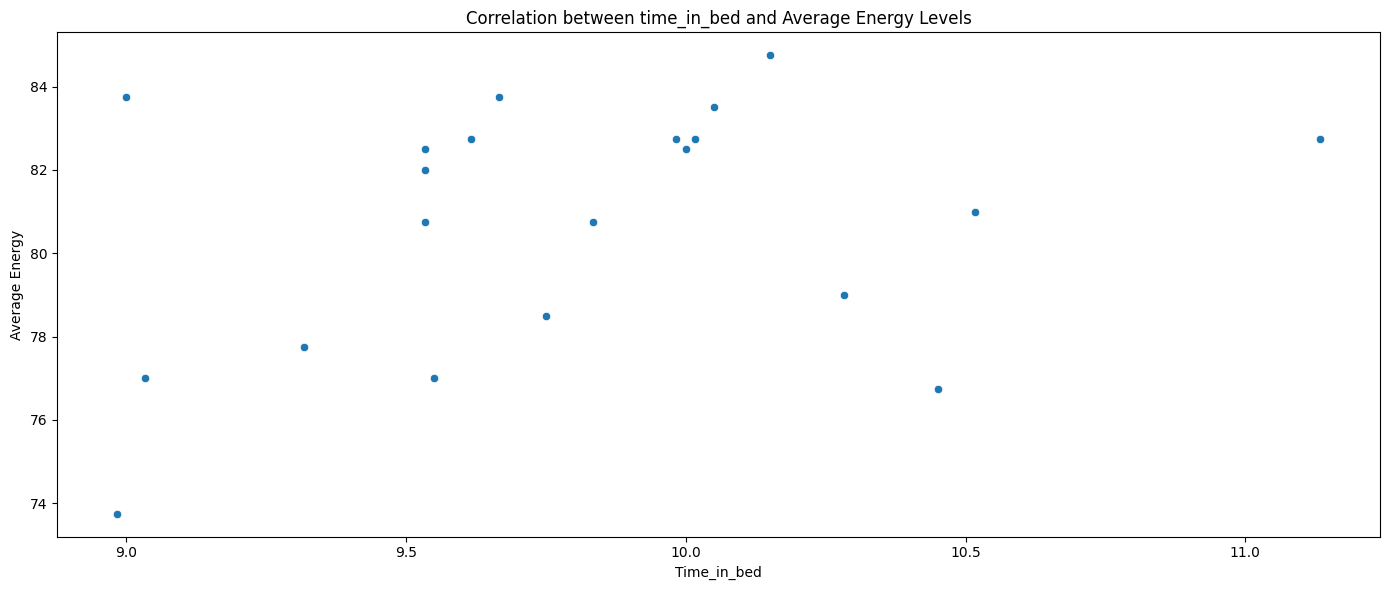

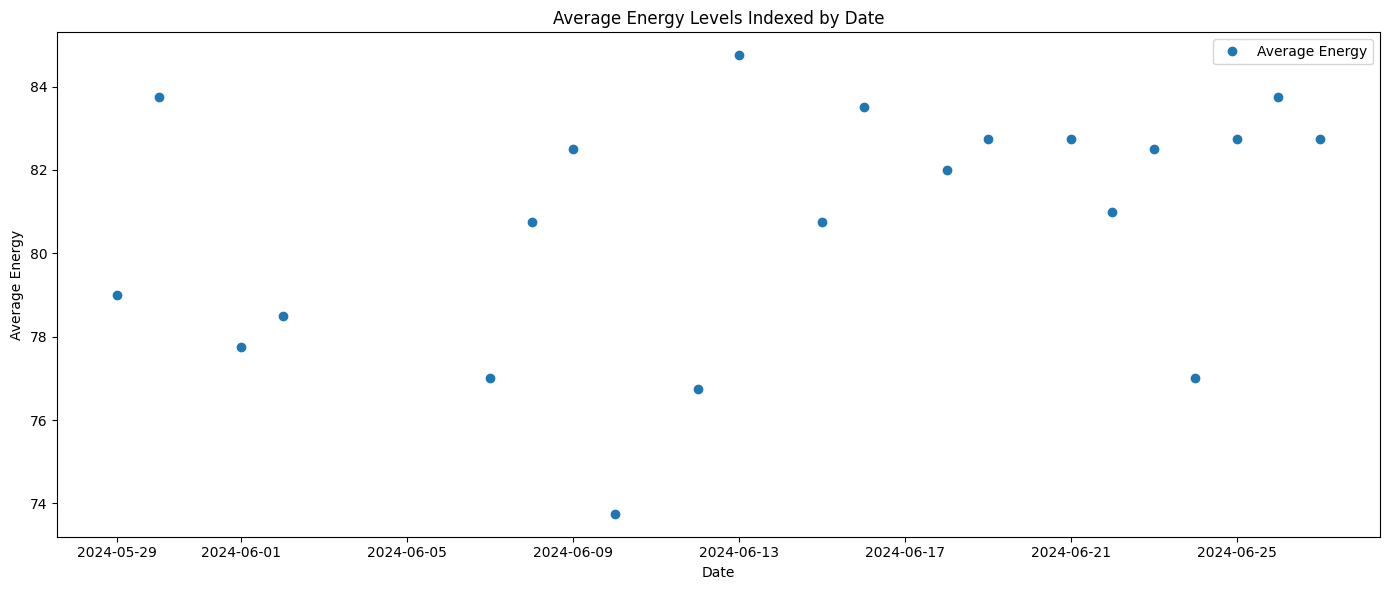

Pearson correlation between sleep_duration and average energy levels: 0.087
P-value: 0.708


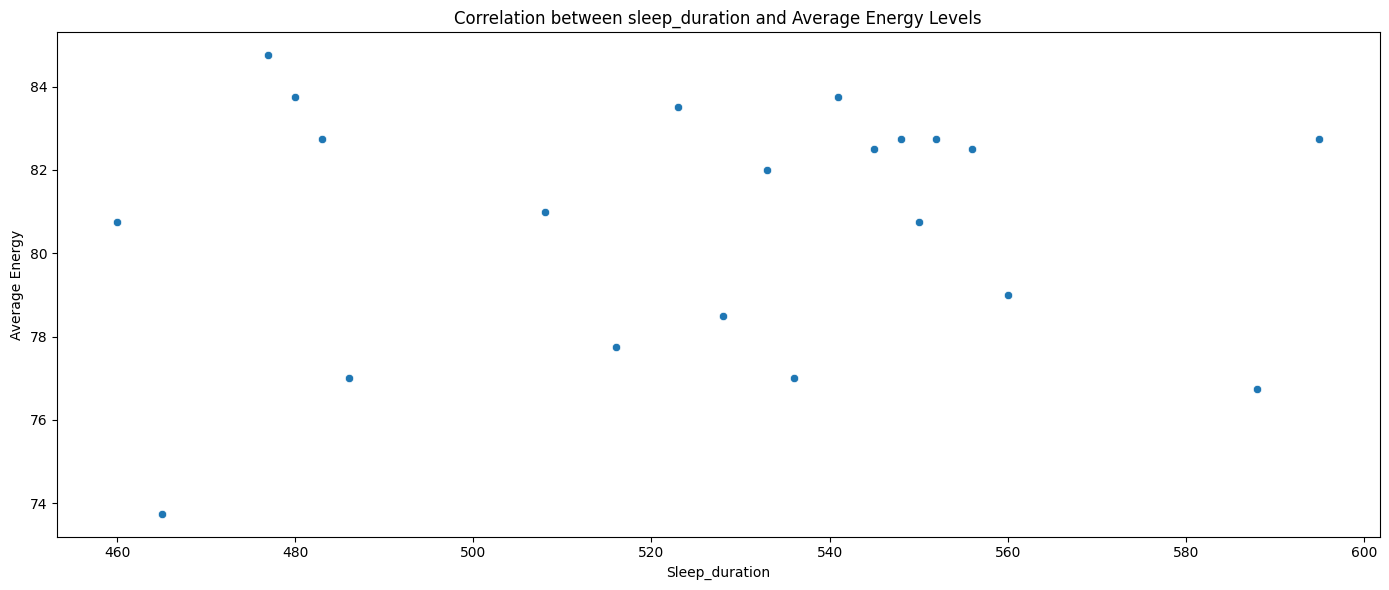

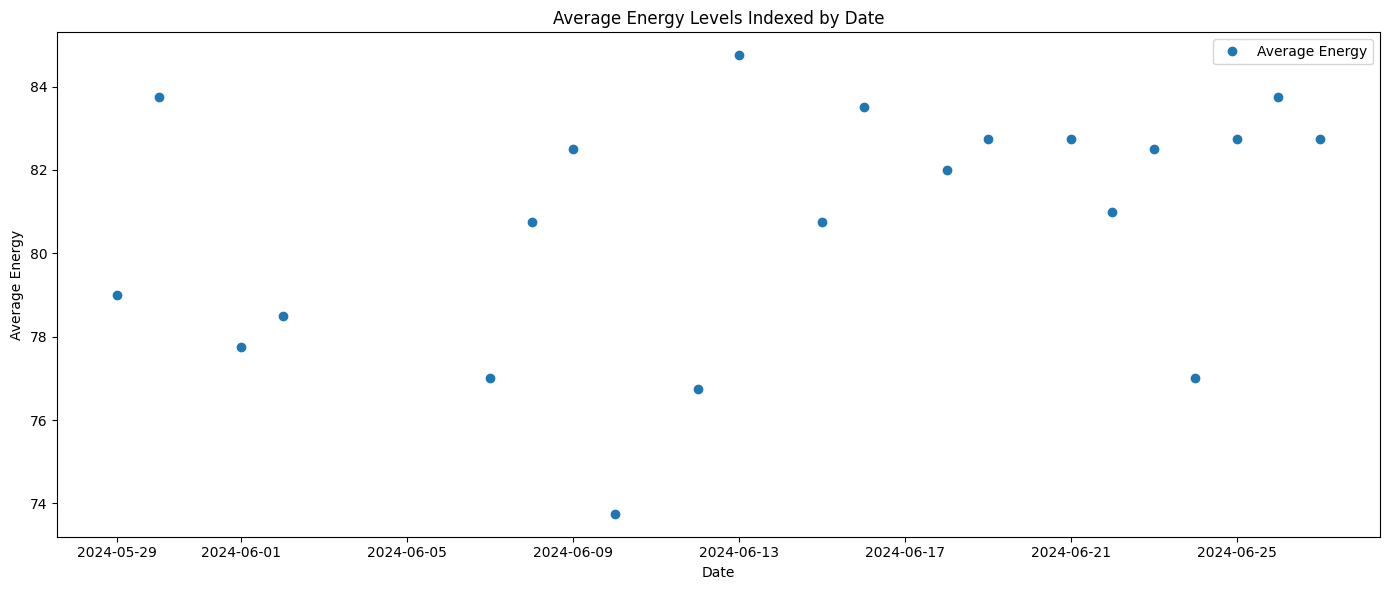

Pearson correlation between potassium and average energy levels: -0.132
P-value: 0.567


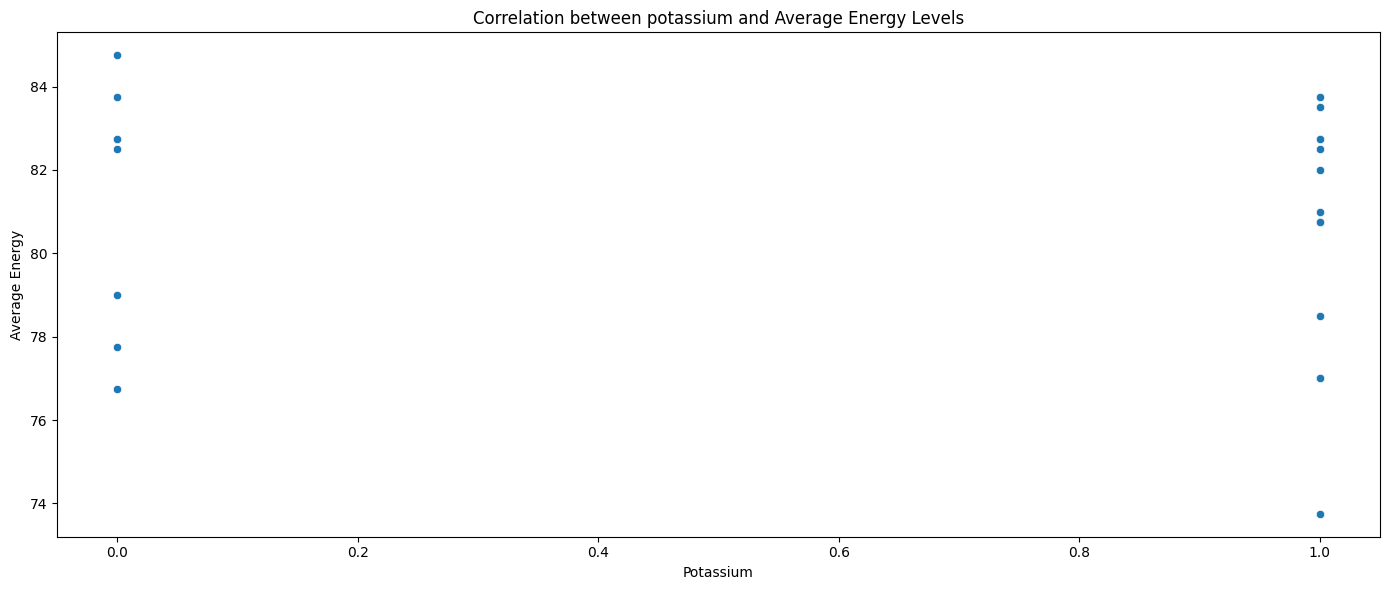

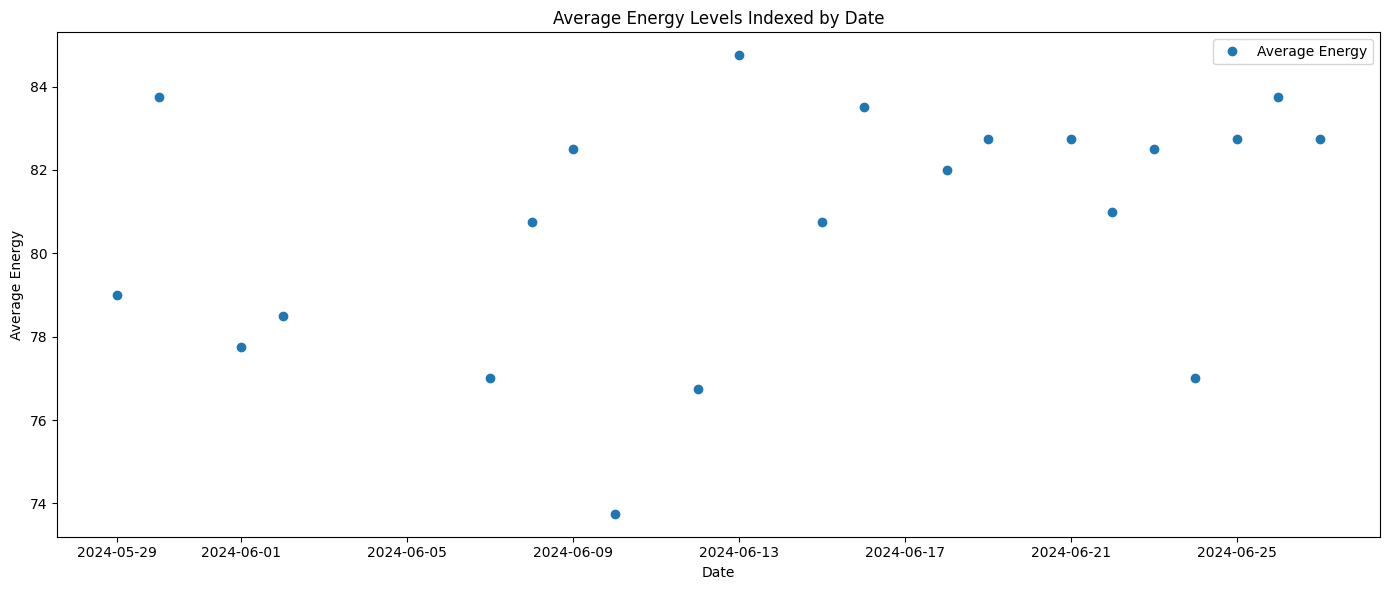

Pearson correlation between grey and average energy levels: -0.185
P-value: 0.422


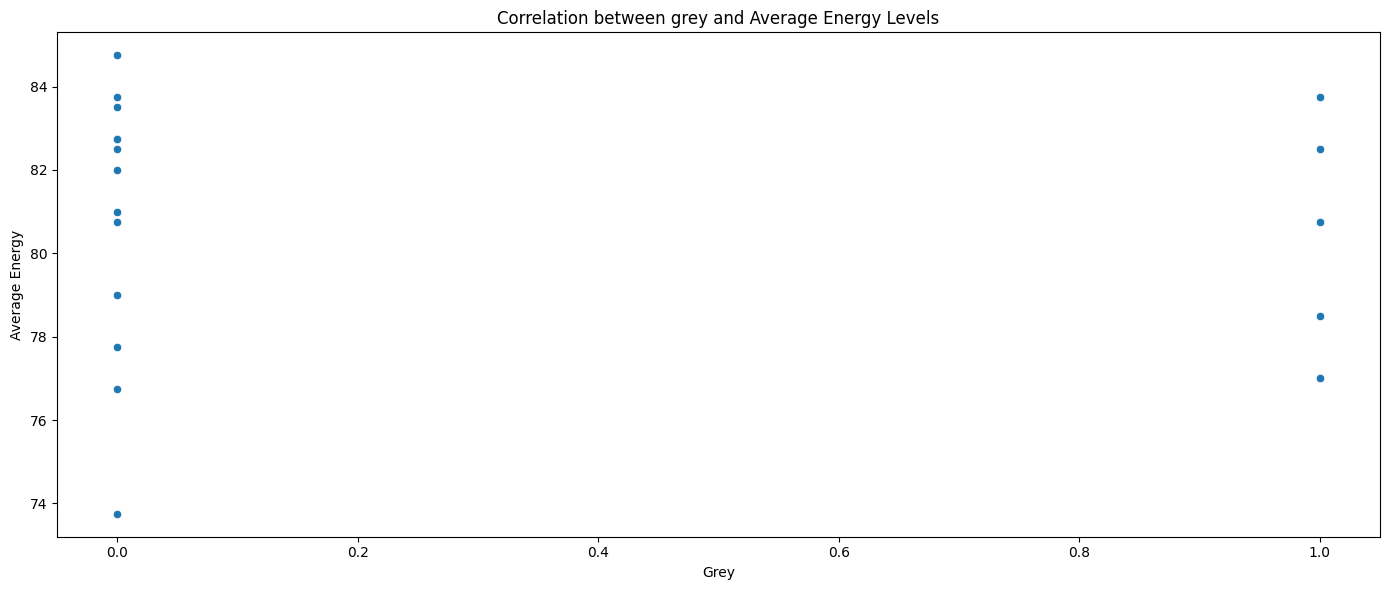

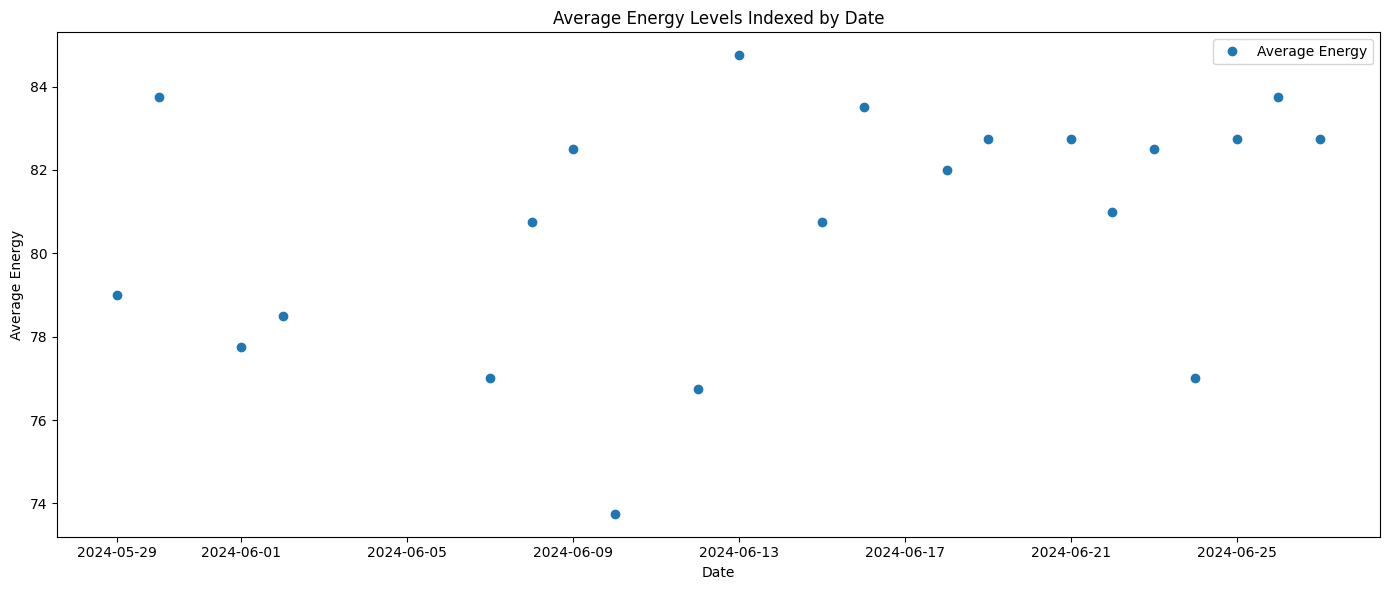

Pearson correlation between omega3 and average energy levels: 0.203
P-value: 0.377


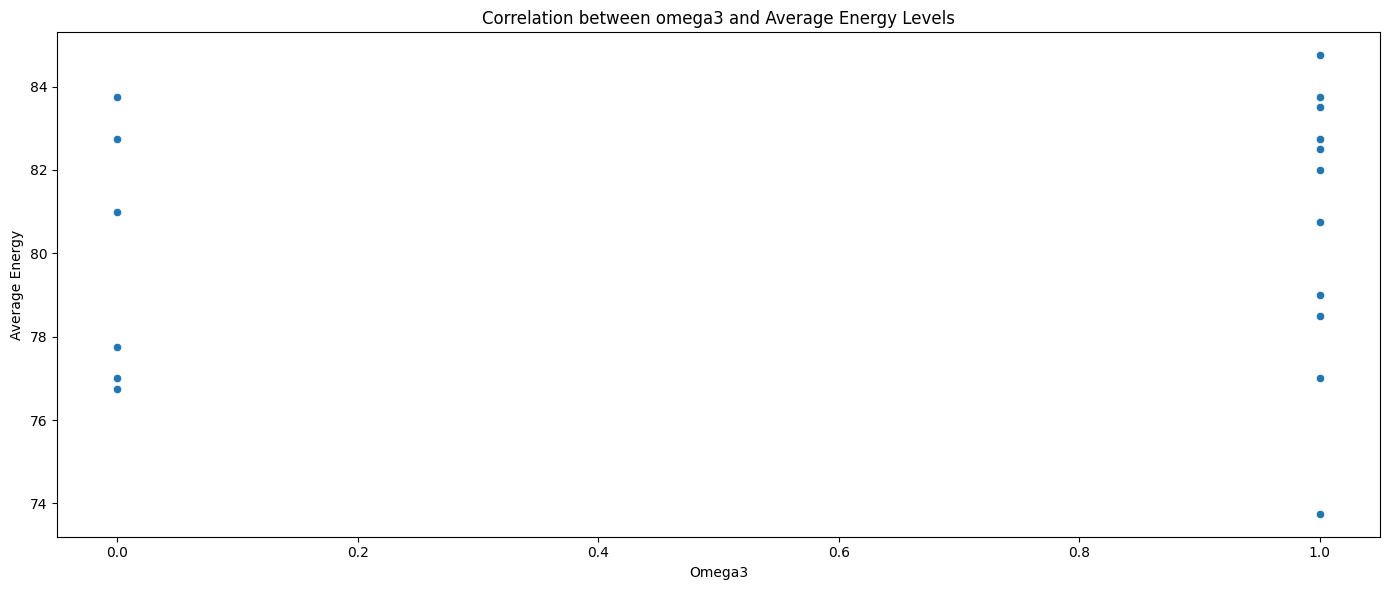

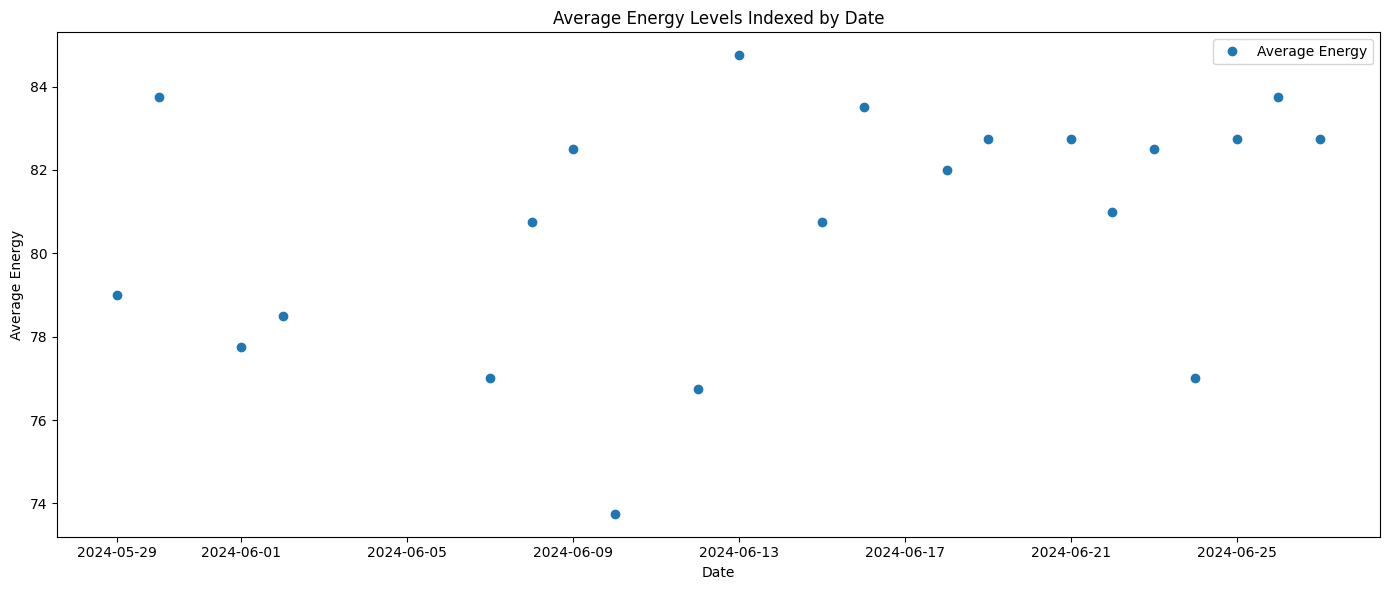

Pearson correlation between vitamin_d and average energy levels: -0.013
P-value: 0.957


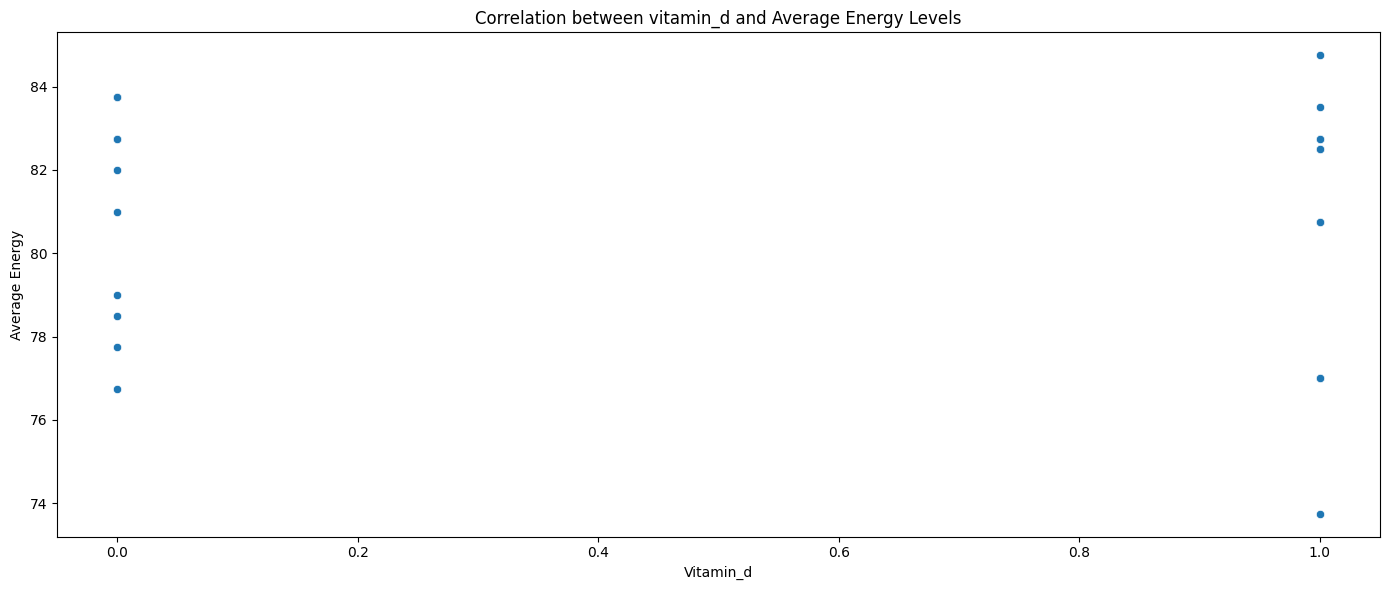

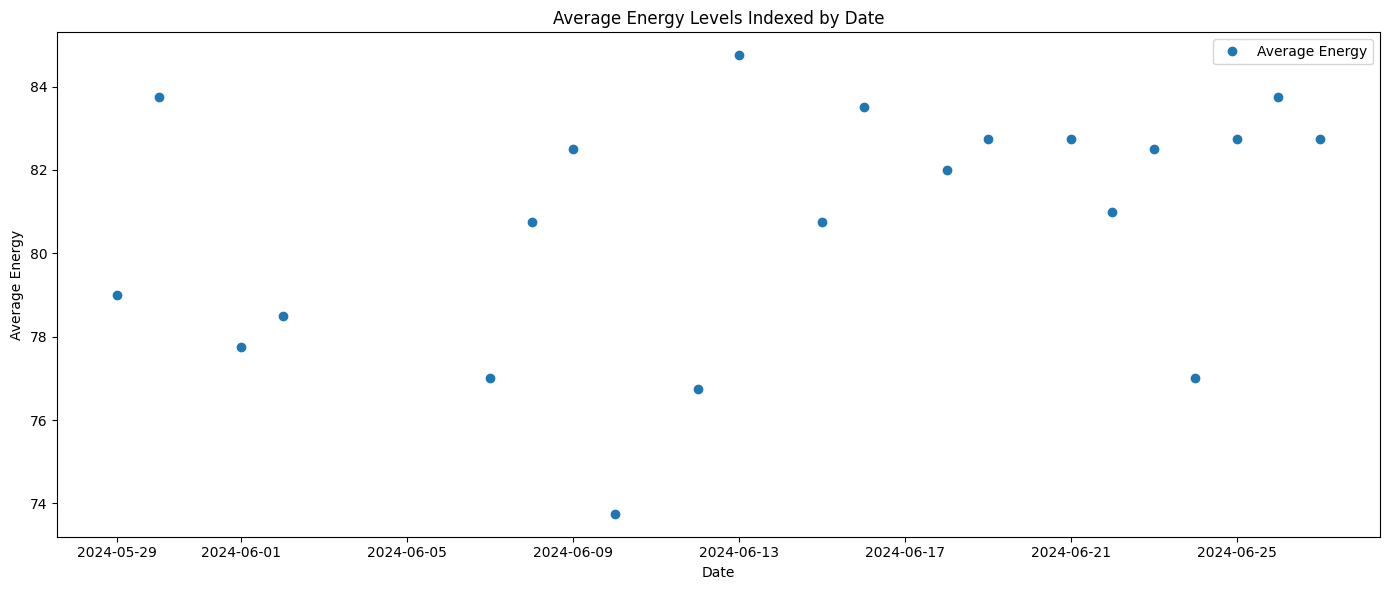

Pearson correlation between creatine and average energy levels: 0.114
P-value: 0.624


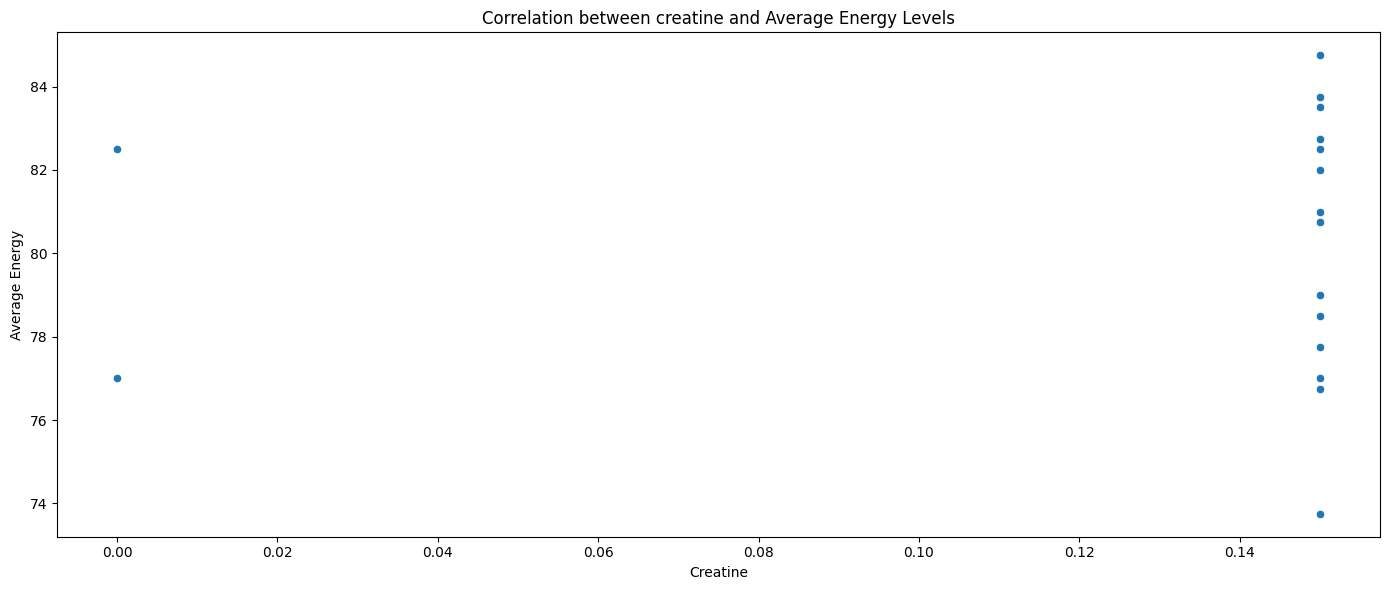

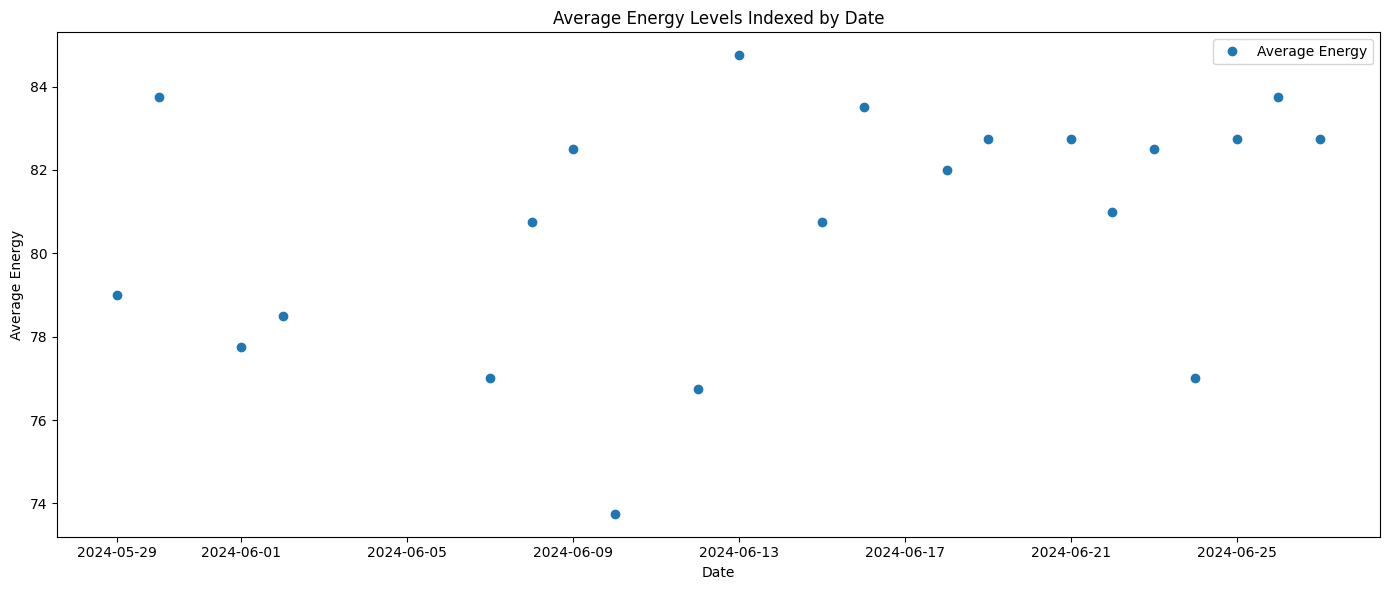

Pearson correlation between masturbate and average energy levels: -0.392
P-value: 0.079


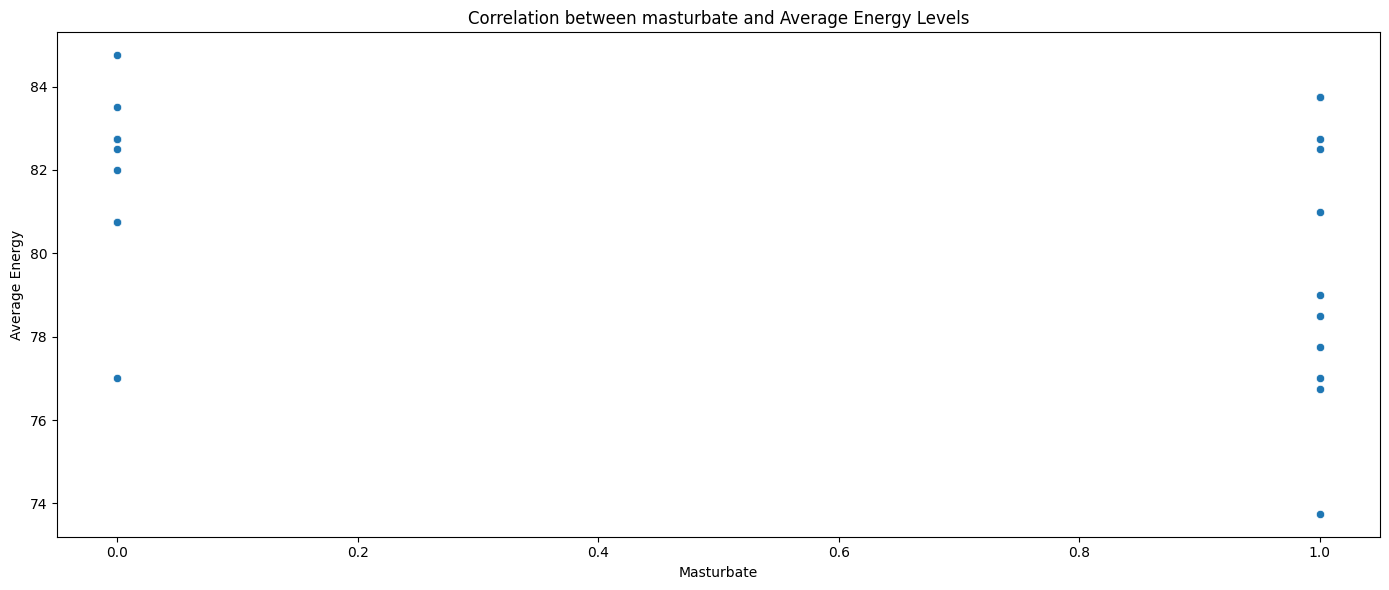

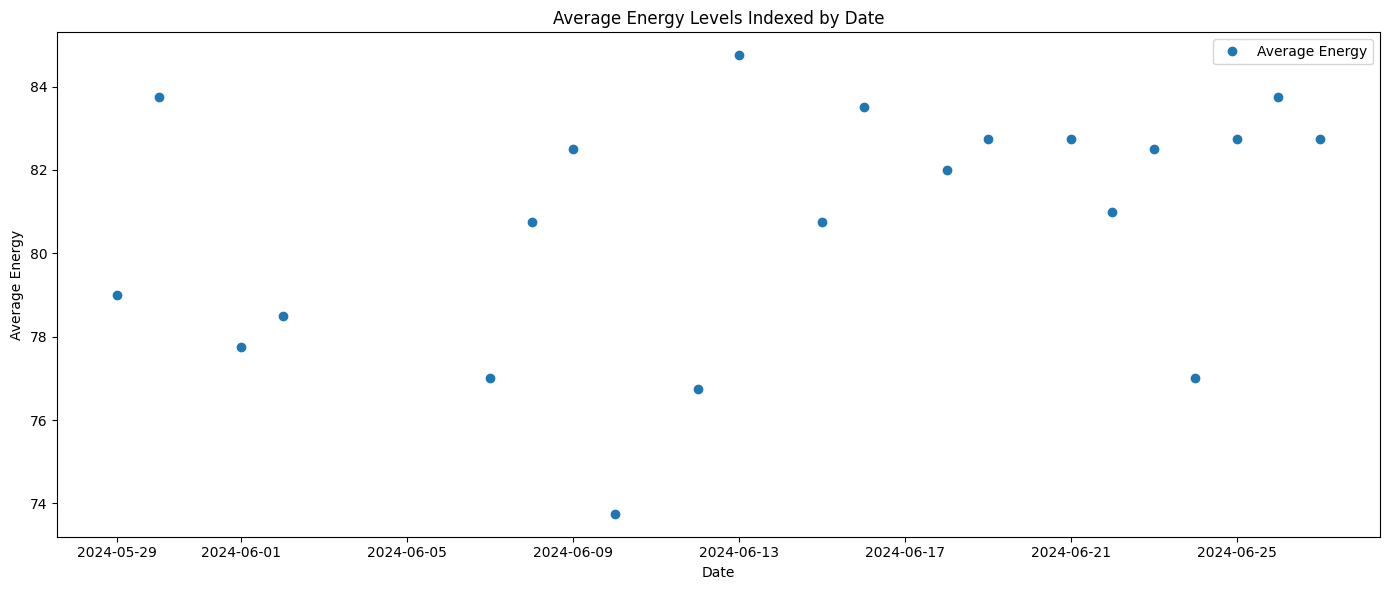

Pearson correlation between melatonin and average energy levels: 0.114
P-value: 0.624


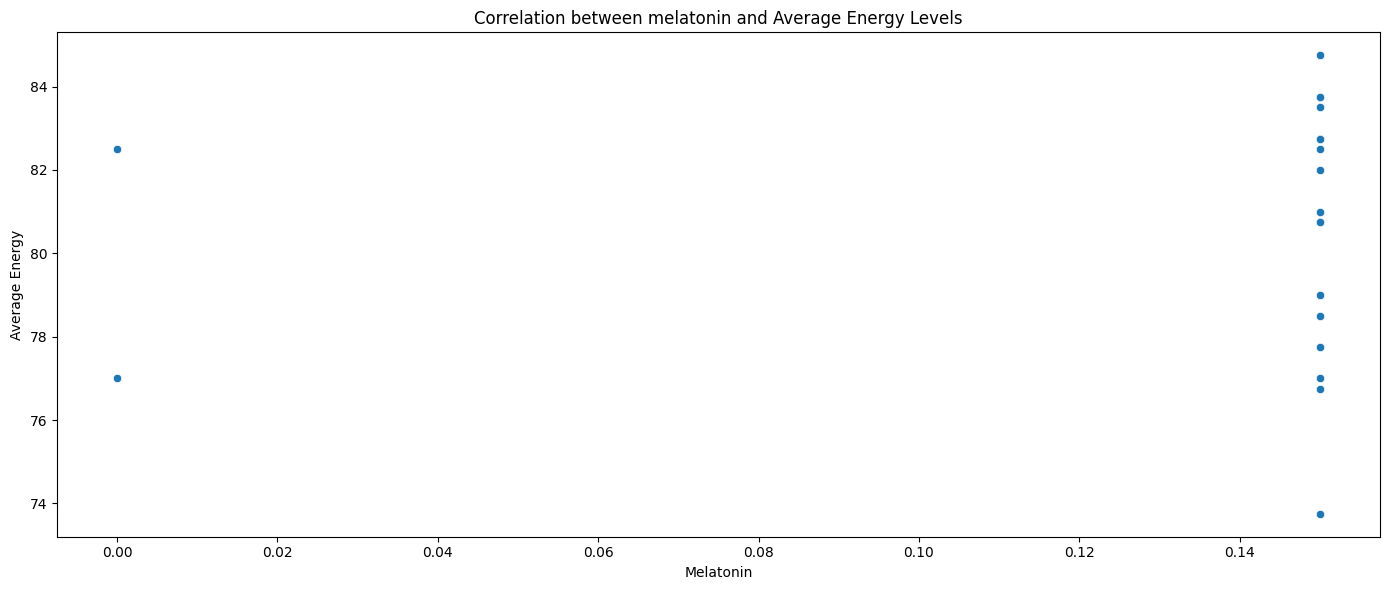

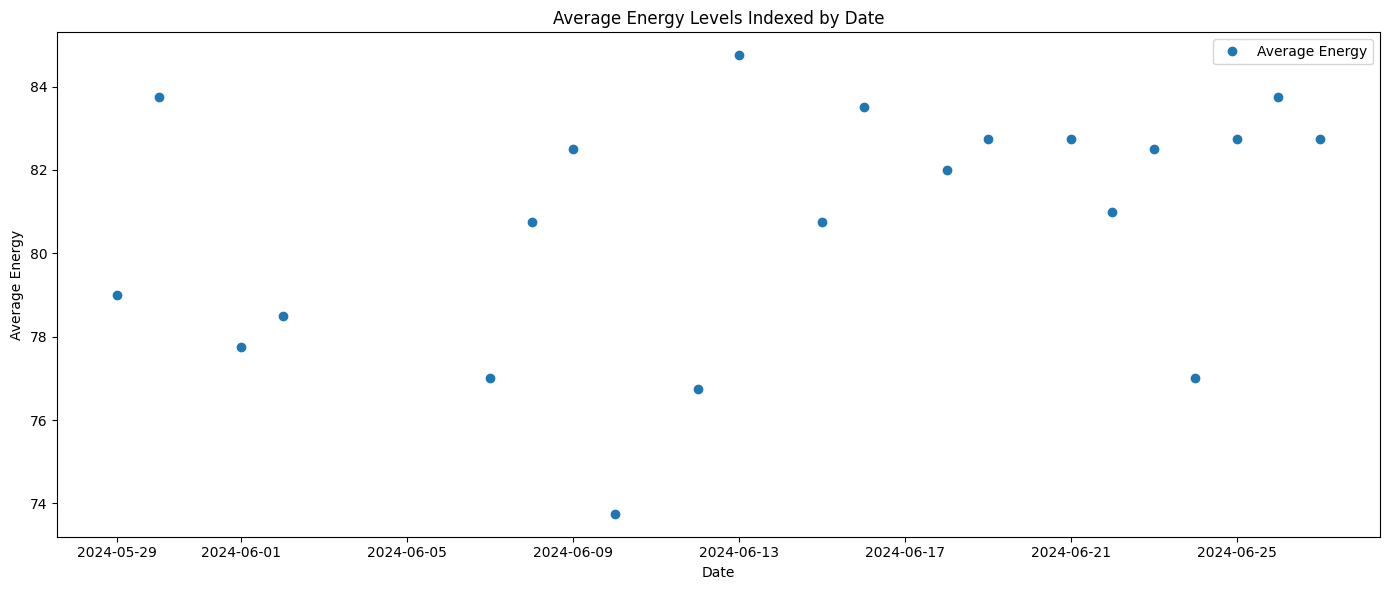

Pearson correlation between caffeine and average energy levels: 0.316
P-value: 0.163


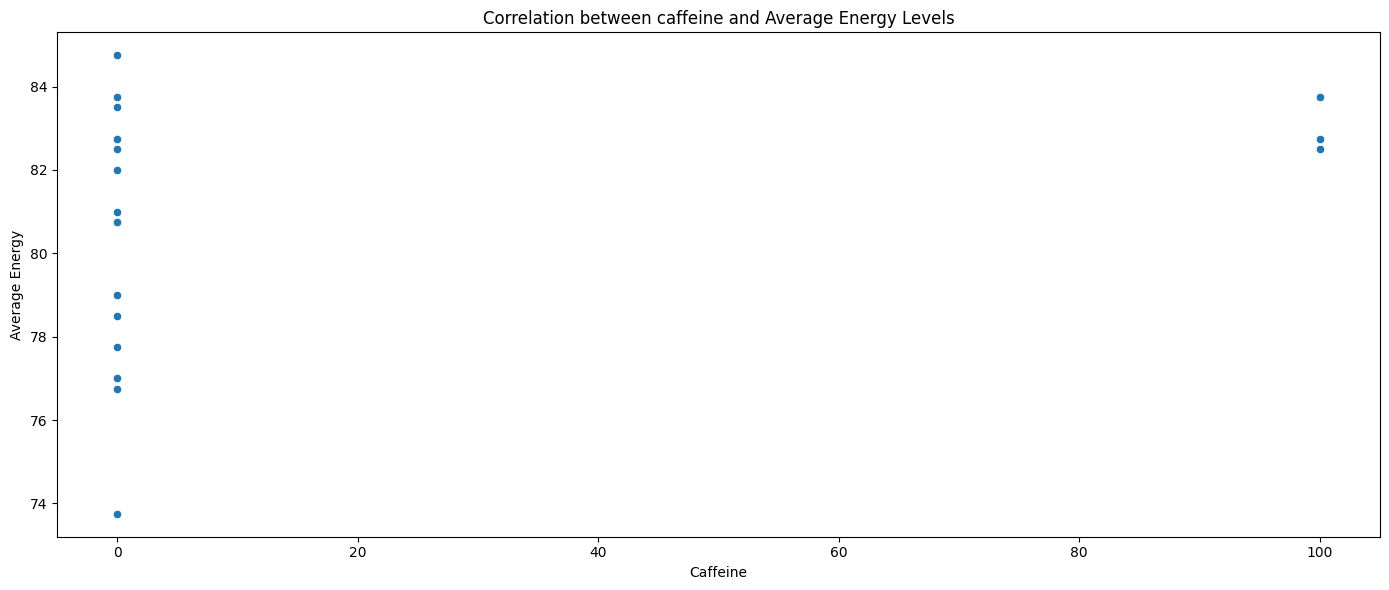

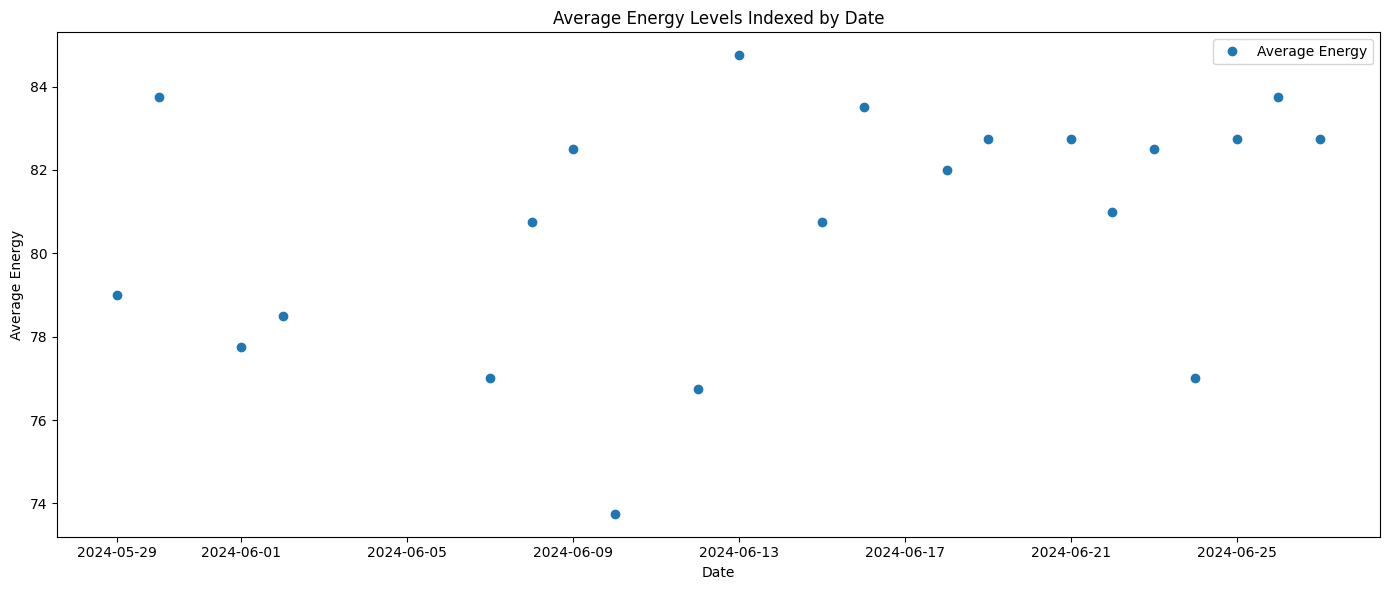

ValueError: `x` and `y` must have the same length along `axis`.

In [129]:
for column in ['time_in_bed', 'sleep_duration', 'potassium', 'grey', 'omega3', 'vitamin_d', 'creatine', 'masturbate', 'melatonin', 'caffeine', 'porn']:
    if column == 'time_in_bed':
        analyze_energy_levels_correlation(filtered_data, '2024-05-29', '2024-06-28', column)
    else:
        analyze_energy_levels_correlation(data, '2024-05-29', '2024-06-28', column)

In [ ]:
analyze_energy_levels_correlation(data)

Pearson correlation between shifted masturbate and average energy levels: -0.243
P-value: 0.288


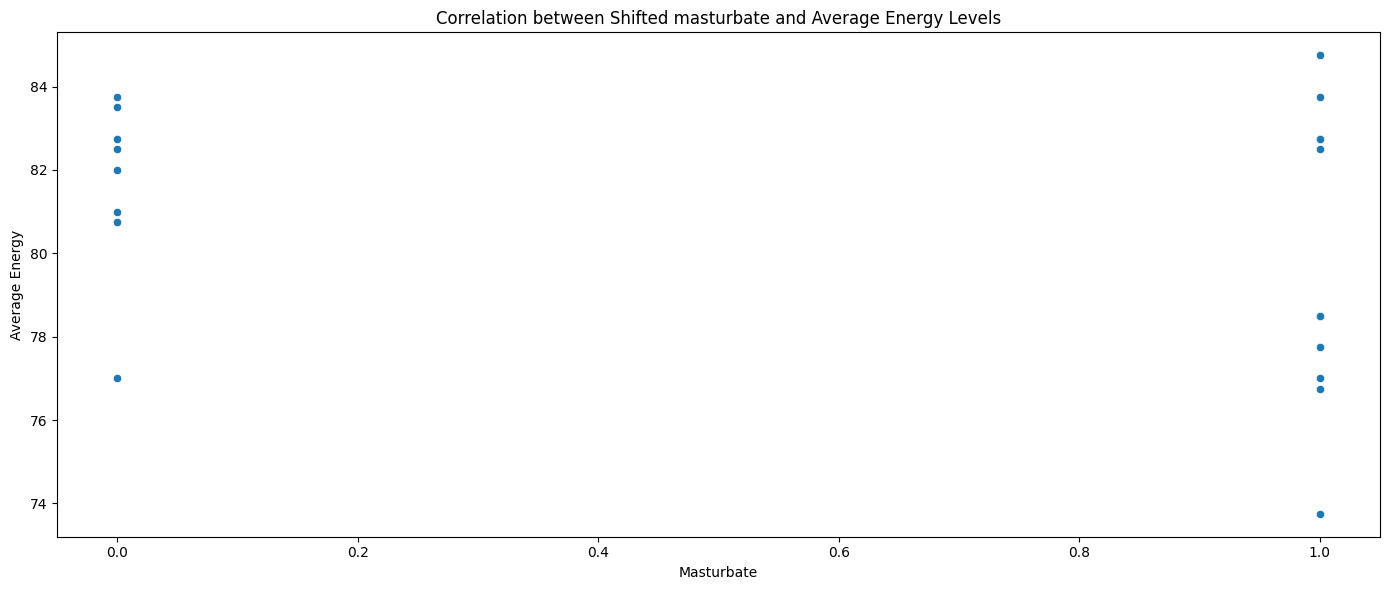

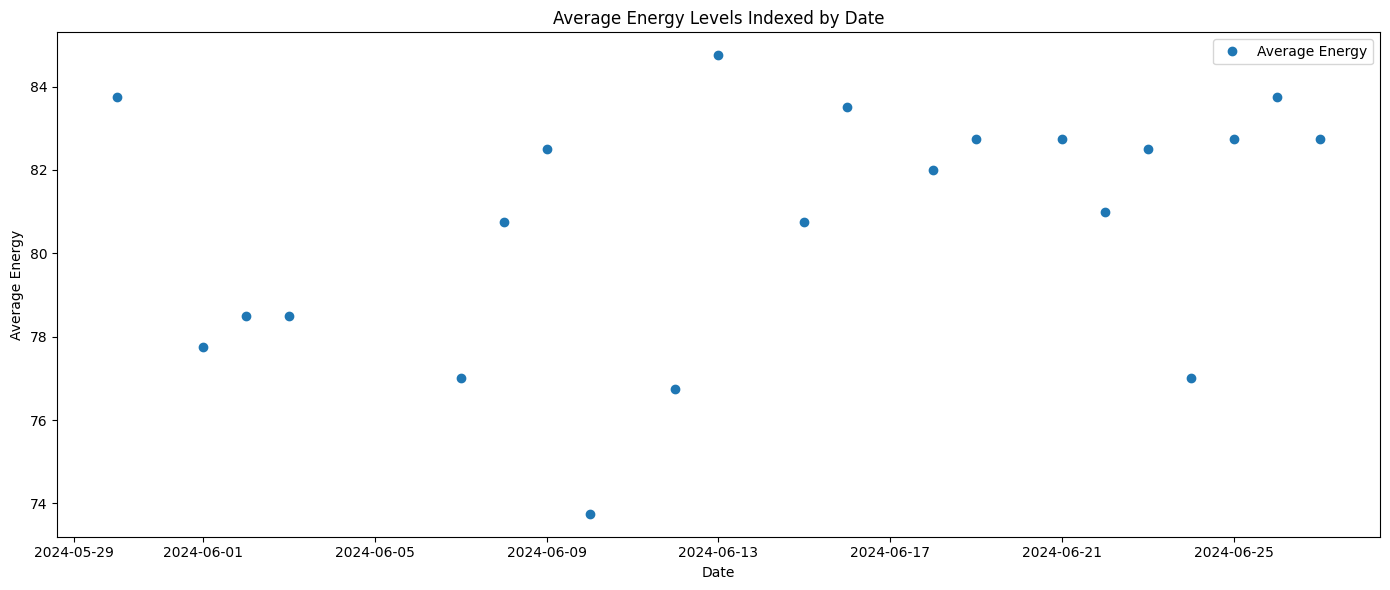

In [31]:

analyze_energy_levels_correlation(data, '2024-05-29', '2024-06-28', 'masturbate',shift_days=-1)

In [30]:
data.creatine
data.creatine = pd.to_datetime()

Date
2024-05-24      -
2024-05-25      1
2024-05-26      0
2024-05-27      1
2024-05-28      0
2024-05-29      1
2024-05-30      1
2024-05-31      0
2024-06-01      0
2024-06-02      1
2024-06-03      1
2024-06-04    NaN
2024-06-05    NaN
2024-06-06      -
2024-06-07      0
2024-06-08      1
2024-06-09      1
2024-06-10      1
2024-06-11      -
2024-06-12      0
2024-06-13      1
2024-06-14      0
2024-06-15      1
2024-06-16      0
2024-06-17      0
2024-06-18      1
2024-06-19      1
2024-06-20      0
2024-06-21      1
2024-06-22      1
2024-06-23      1
2024-06-24      1
2024-06-25      1
2024-06-26      1
2024-06-27      1
2024-06-28      0
2024-06-29      1
2024-06-30    NaN
NaT           NaN
NaT           NaN
NaT           NaN
NaT           NaN
NaT           NaN
NaT           NaN
NaT           NaN
NaT           NaN
NaT           NaN
NaT           NaN
NaT           NaN
NaT           NaN
NaT           NaN
NaT           NaN
NaT           NaN
NaT           NaN
NaT           NaN
NaT  

Pearson correlation between shifted potassium and average energy levels: -0.083
P-value: 0.714


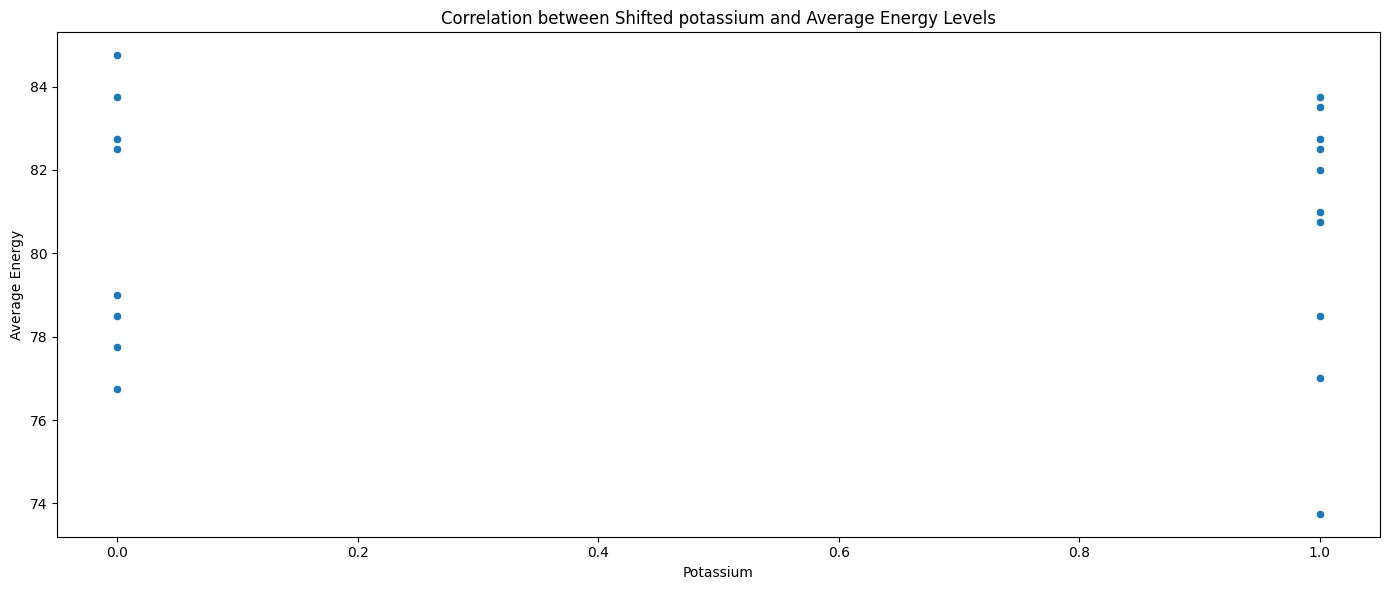

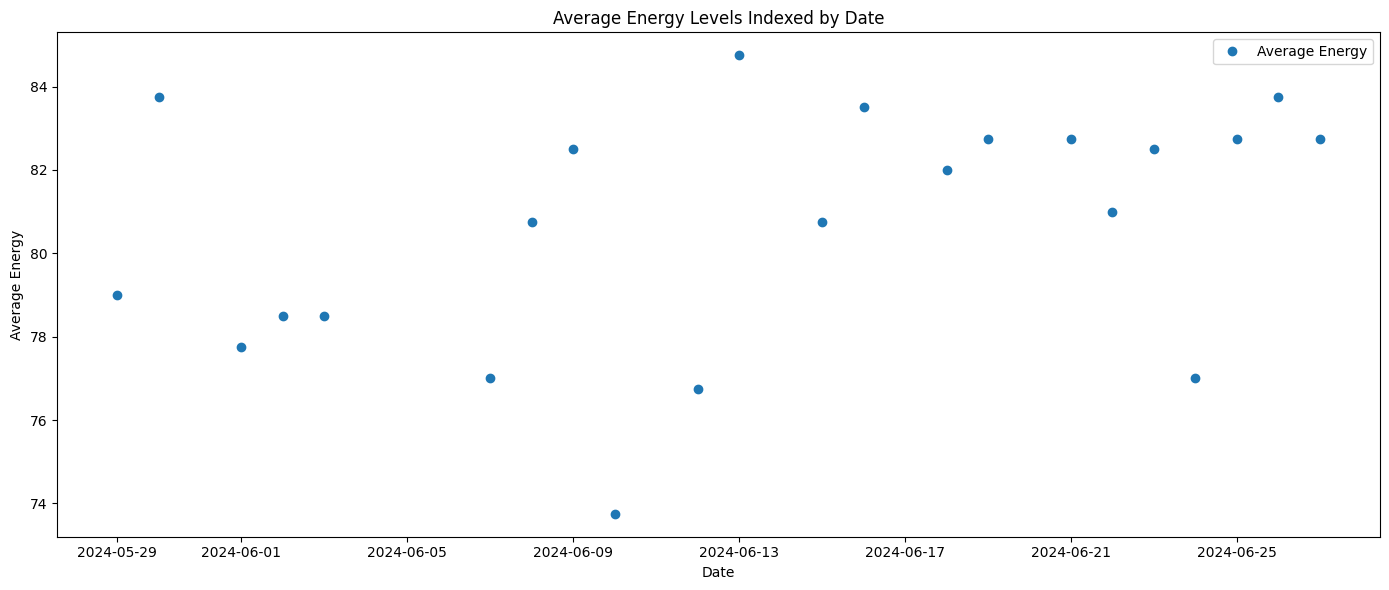

Pearson correlation between shifted omega3 and average energy levels: 0.177
P-value: 0.432


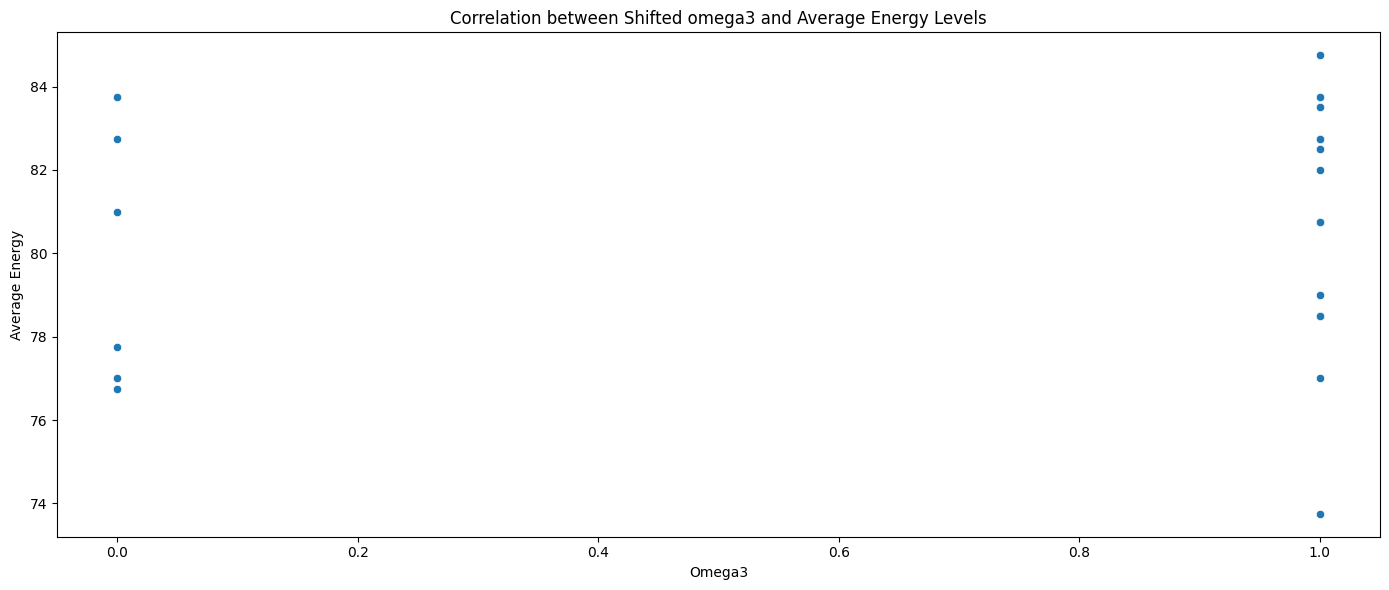

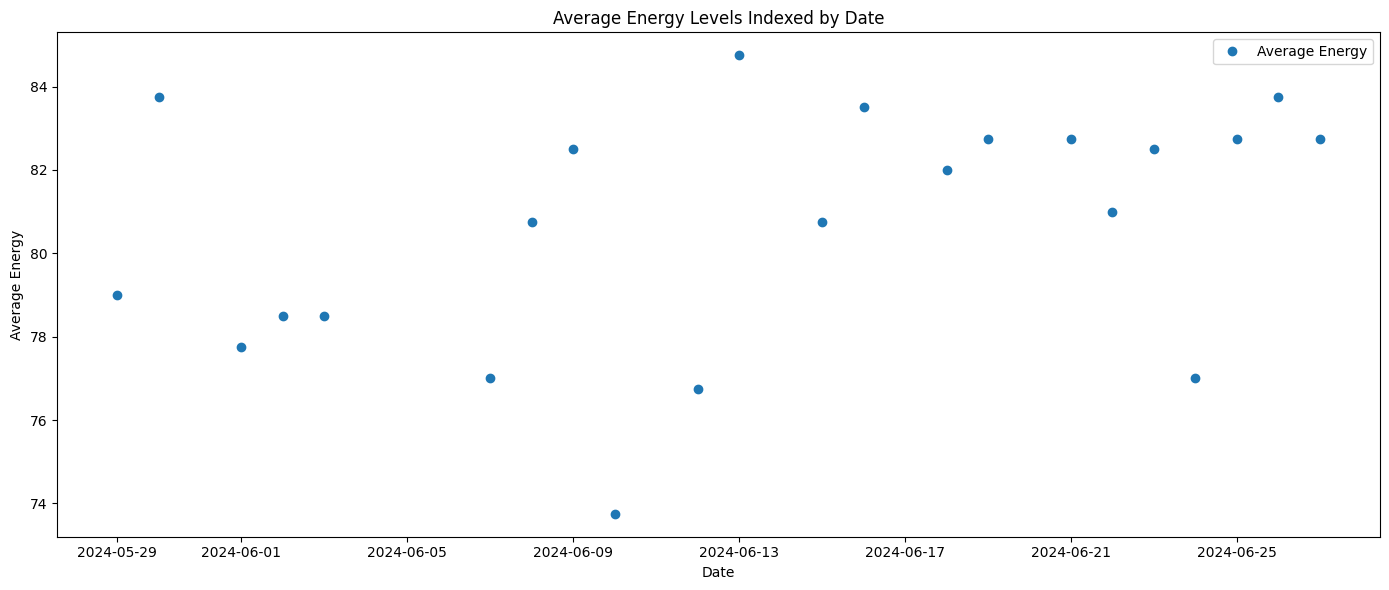

Pearson correlation between shifted grey and average energy levels: -0.225
P-value: 0.313


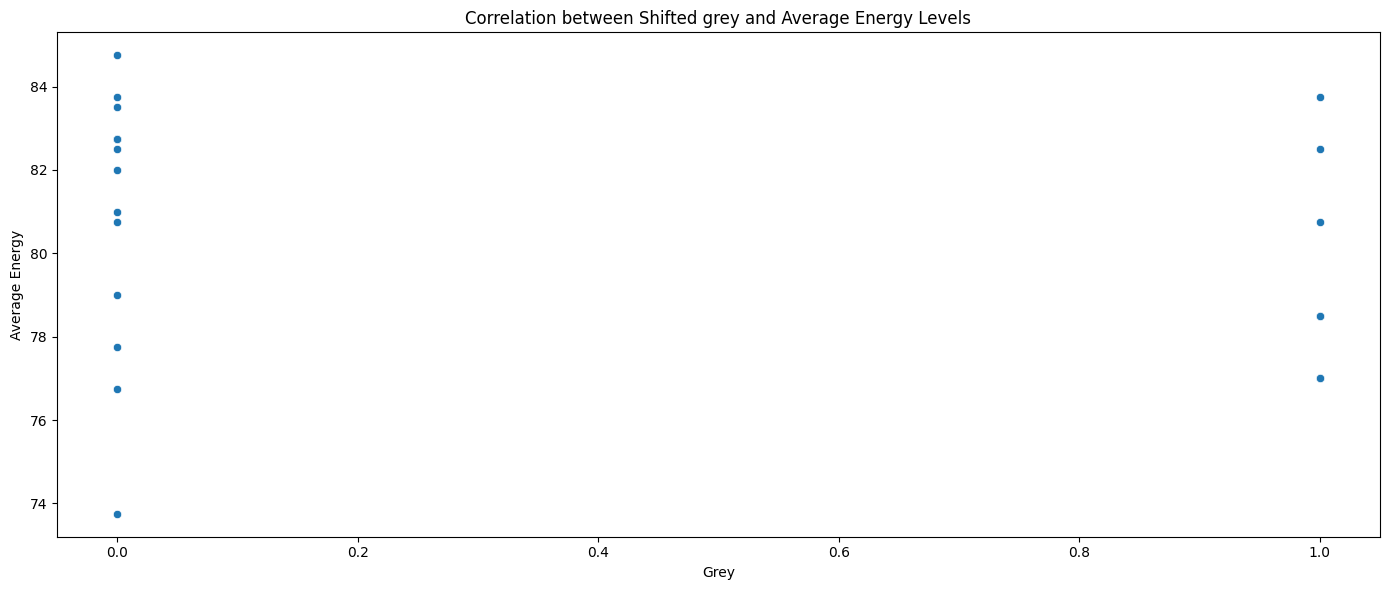

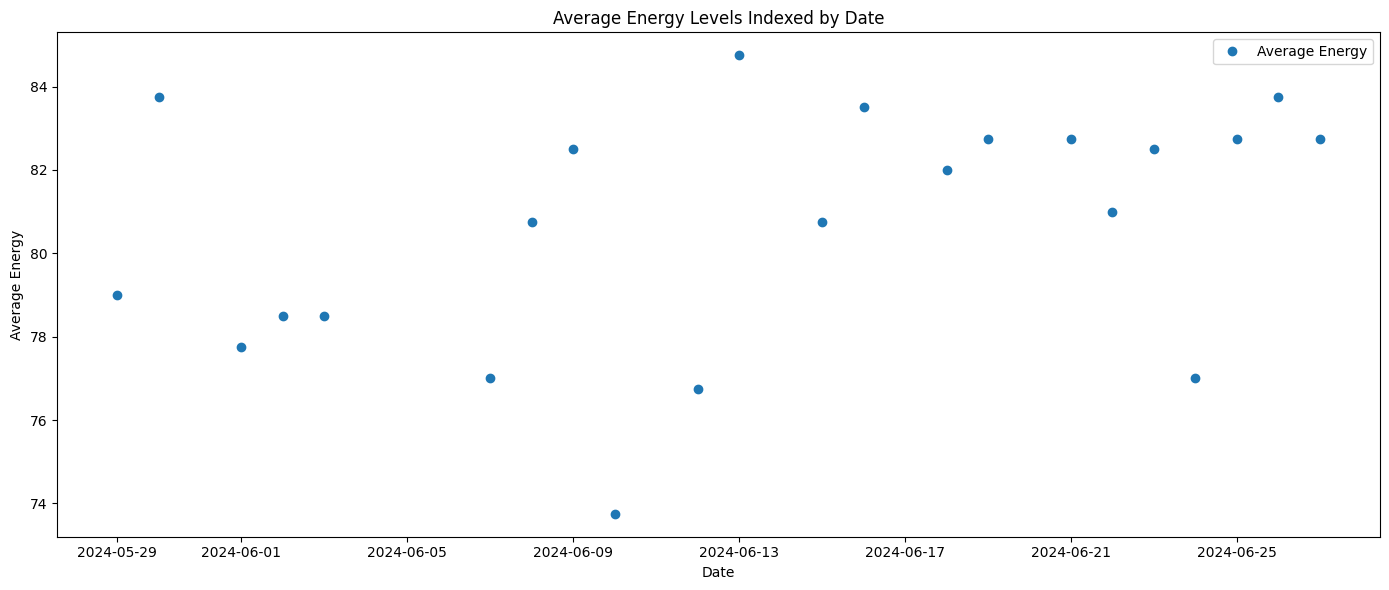

Pearson correlation between shifted vitamin_d and average energy levels: 0.024
P-value: 0.916


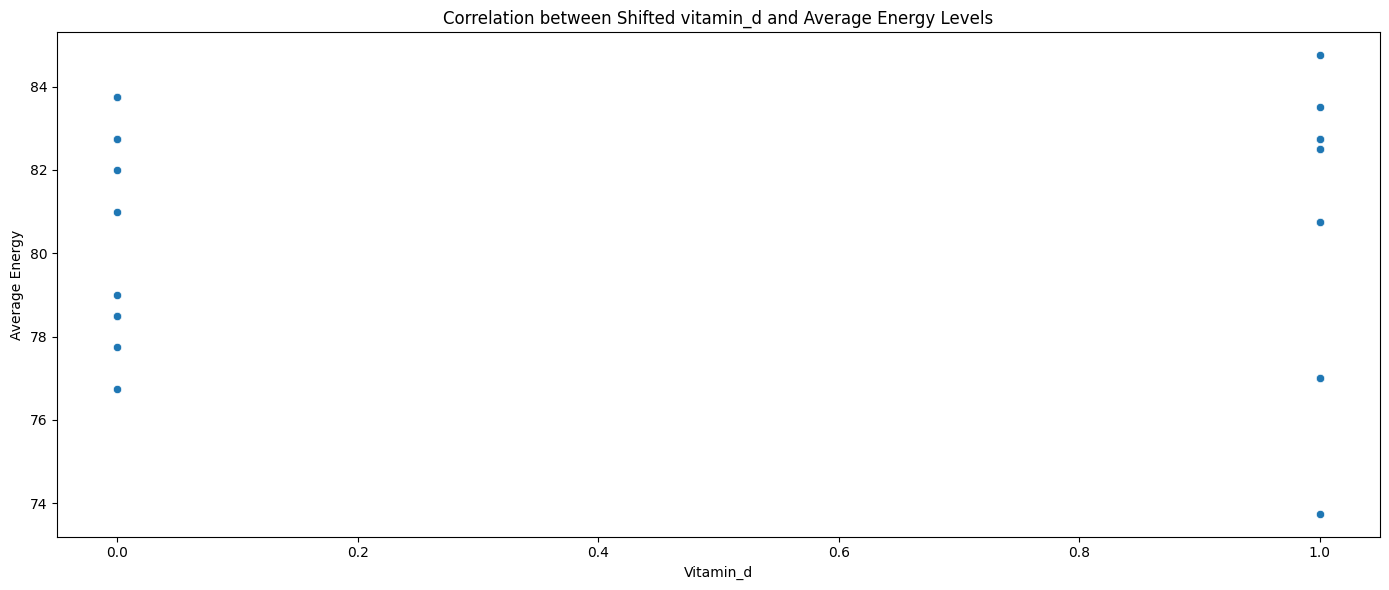

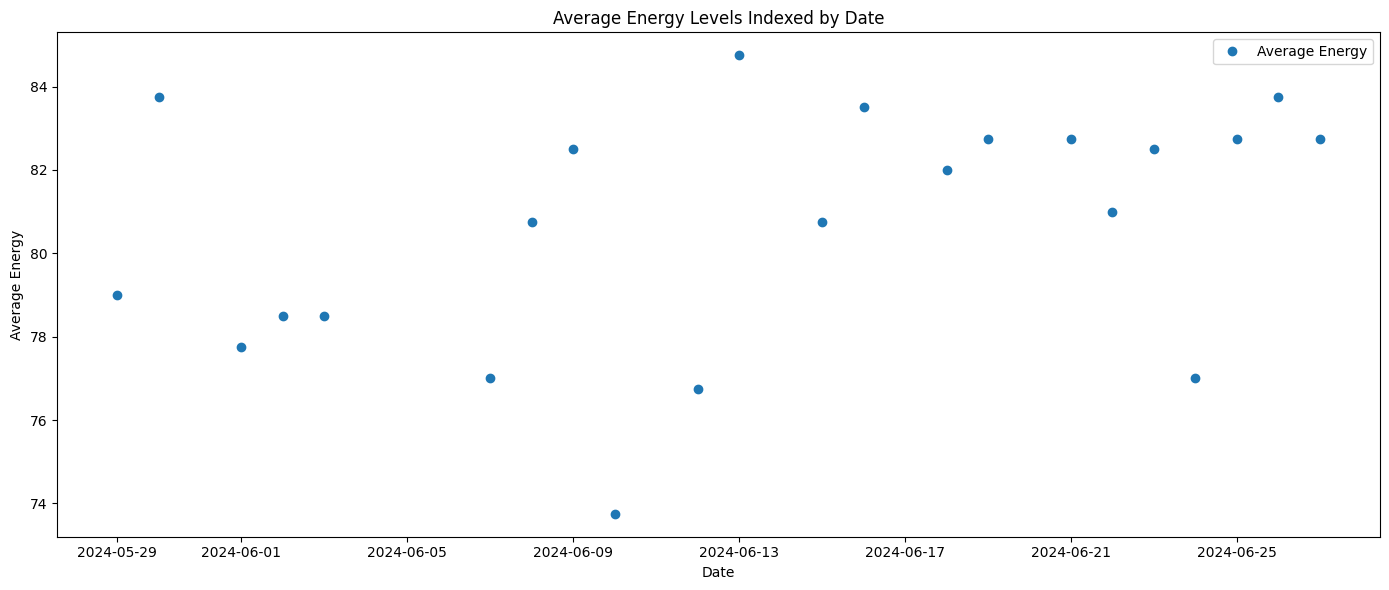

Pearson correlation between shifted methylphenidate and average energy levels: 0.250
P-value: 0.262


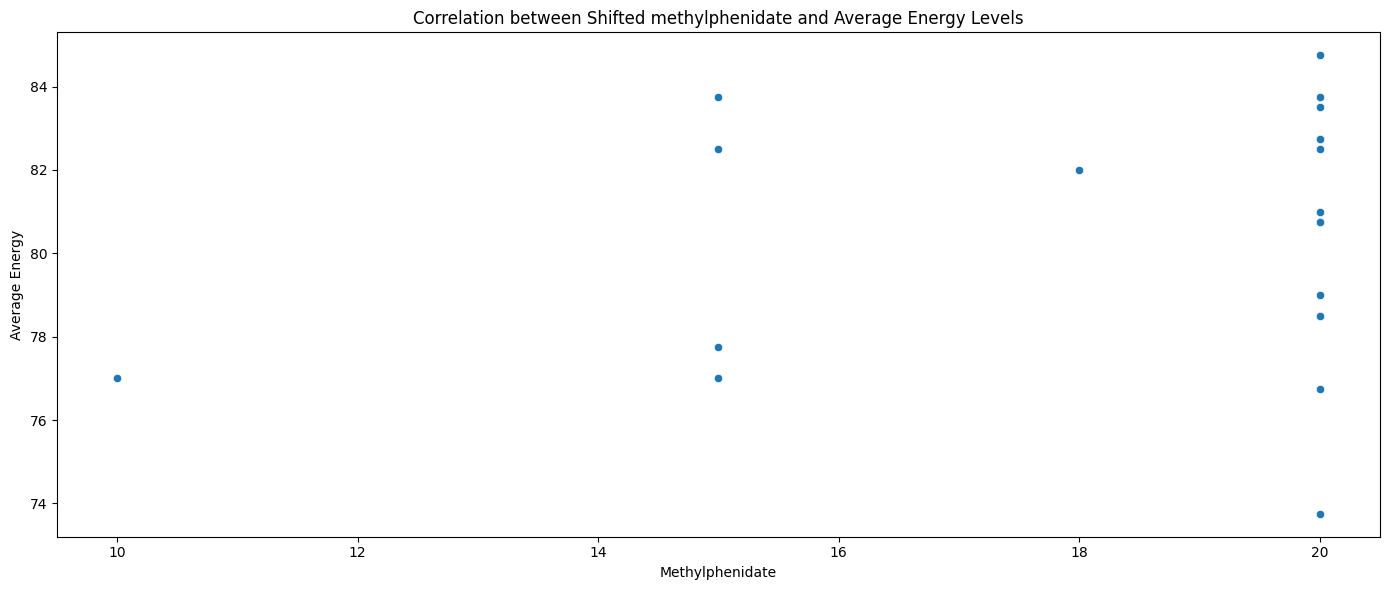

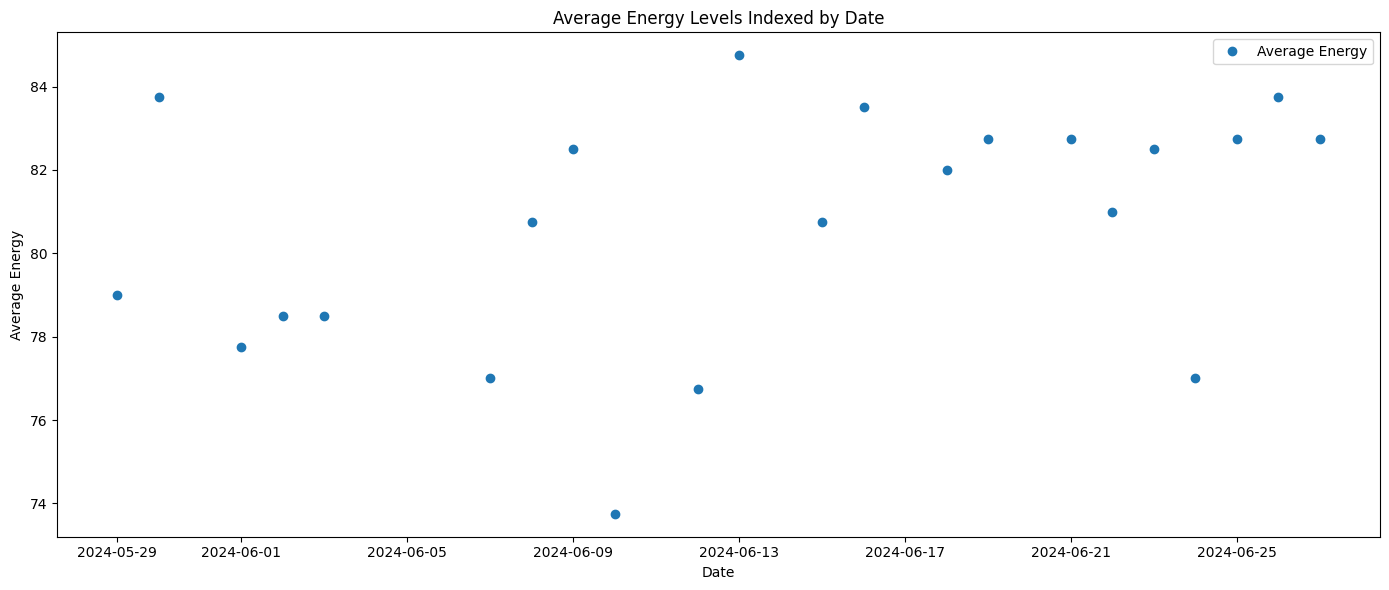

Pearson correlation between shifted caffeine and average energy levels: nan
P-value: nan


/tmp/ipykernel_2727101/822439646.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(filtered_data[column], filtered_data['avg_energy'])


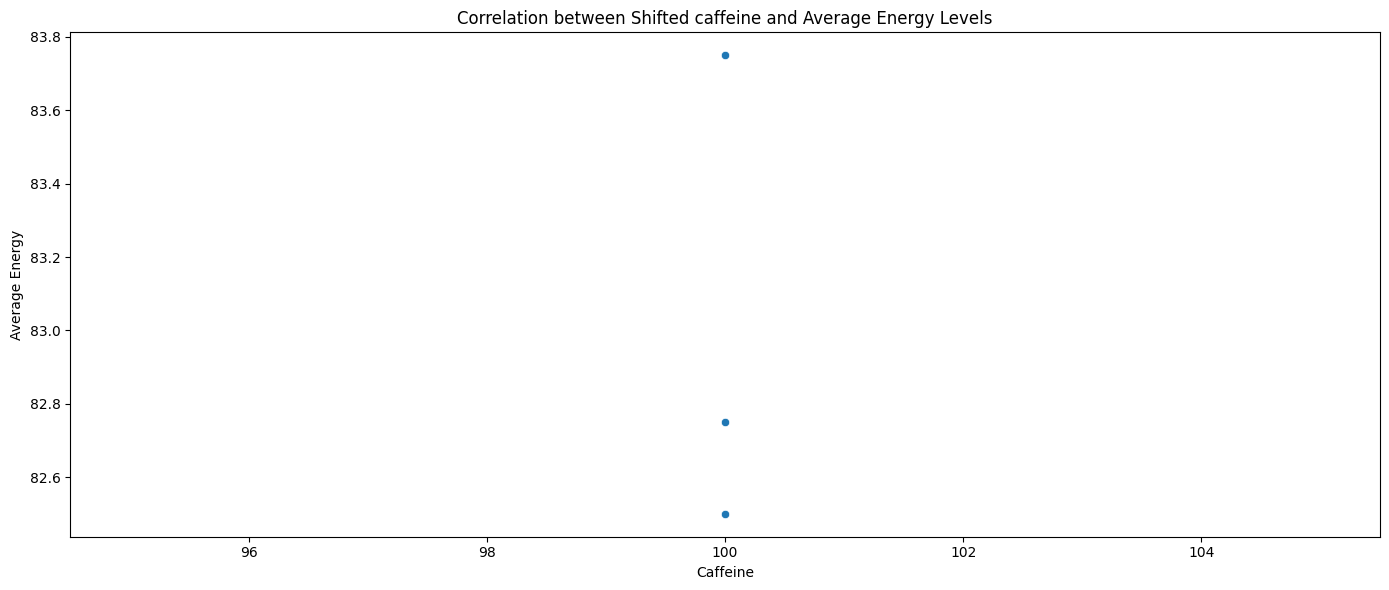

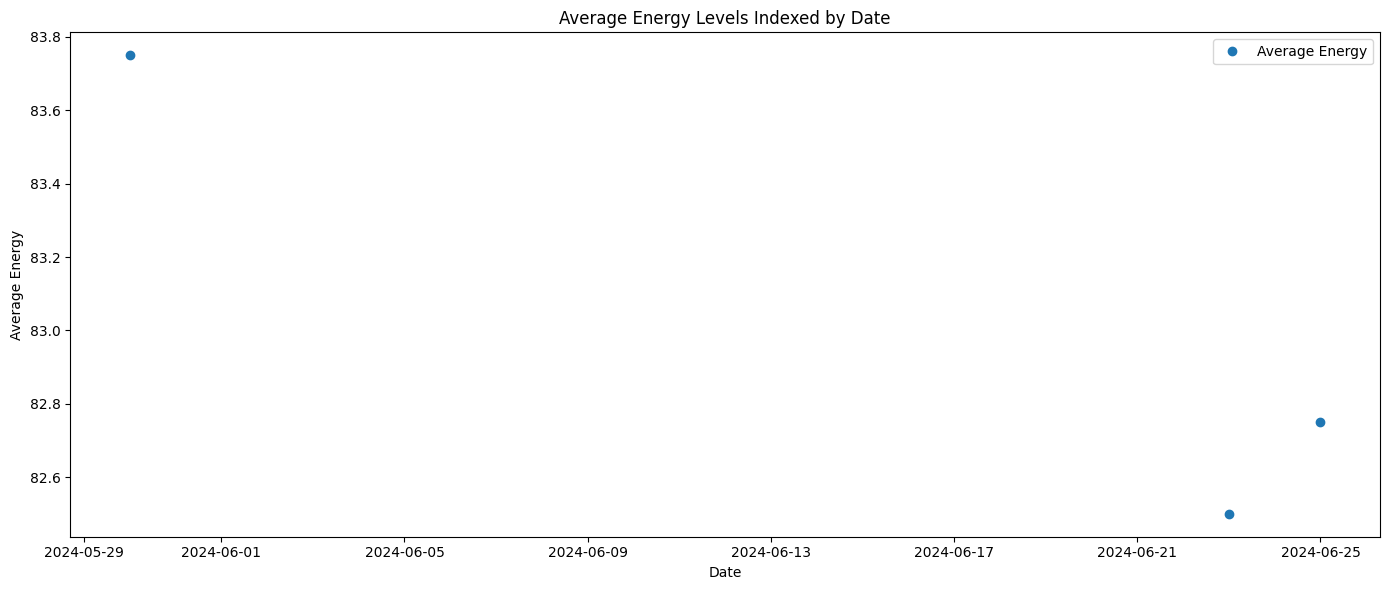

ValueError: data type <class 'numpy.object_'> not inexact

In [29]:
for column in ['potassium', 'omega3', 'grey', 'vitamin_d', 'methylphenidate', 'caffeine', 'creatine']:
    analyze_energy_levels_correlation(data, '2024-05-29', '2024-06-28', column)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


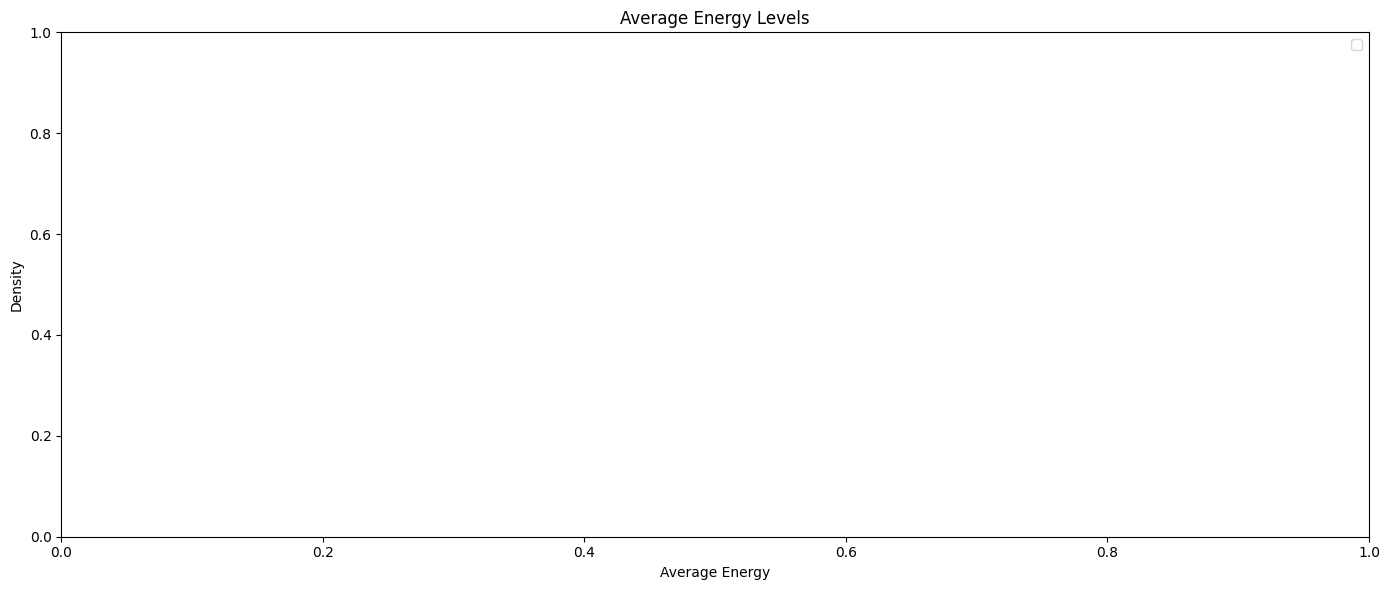

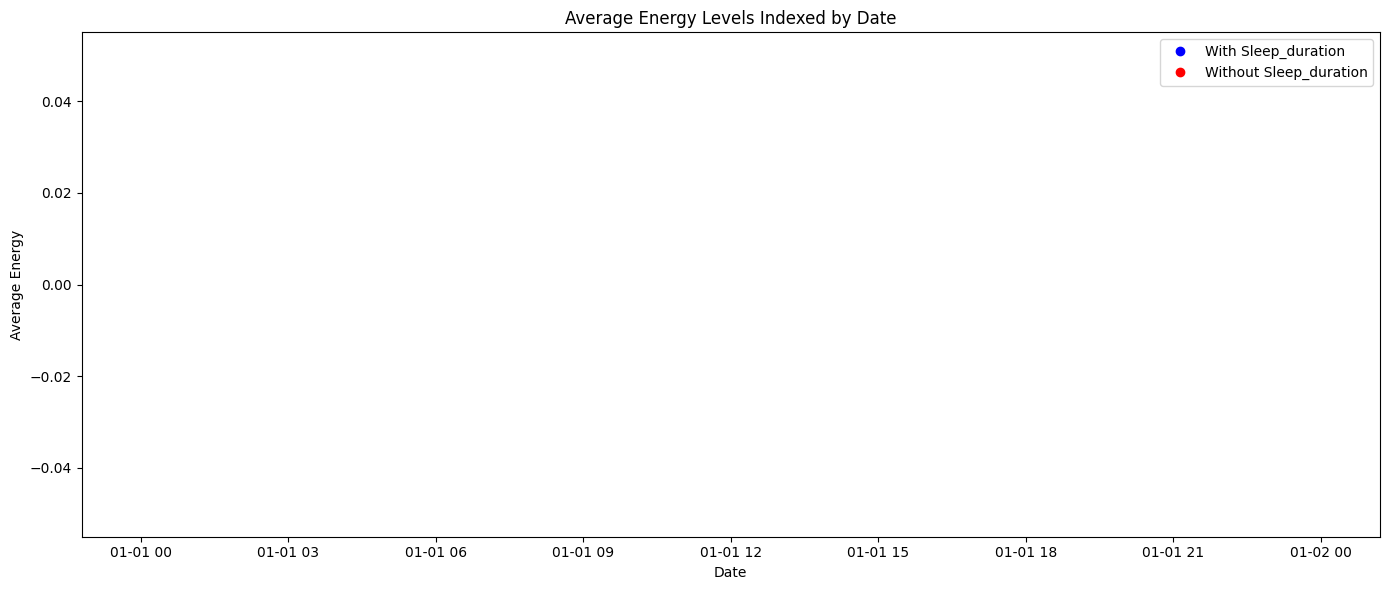

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu1_energy, mu2_energy, sigma1_energy, sigma2_energy]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


Summary for Average Energy Levels Model:
                mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu1_energy     0.081   9.855 -18.071   18.608      0.120    0.115    6722.0   
mu2_energy     0.205  10.048 -18.962   18.764      0.121    0.122    6943.0   
sigma1_energy  8.020   6.108   0.001   18.926      0.089    0.063    3166.0   
sigma2_energy  8.008   6.036   0.002   19.066      0.077    0.055    4202.0   
diff_energy    0.124  13.947 -26.040   25.988      0.172    0.159    6545.0   

               ess_tail  r_hat  
mu1_energy       5176.0    1.0  
mu2_energy       5149.0    1.0  
sigma1_energy    2053.0    1.0  
sigma2_energy    2746.0    1.0  
diff_energy      5629.0    1.0  


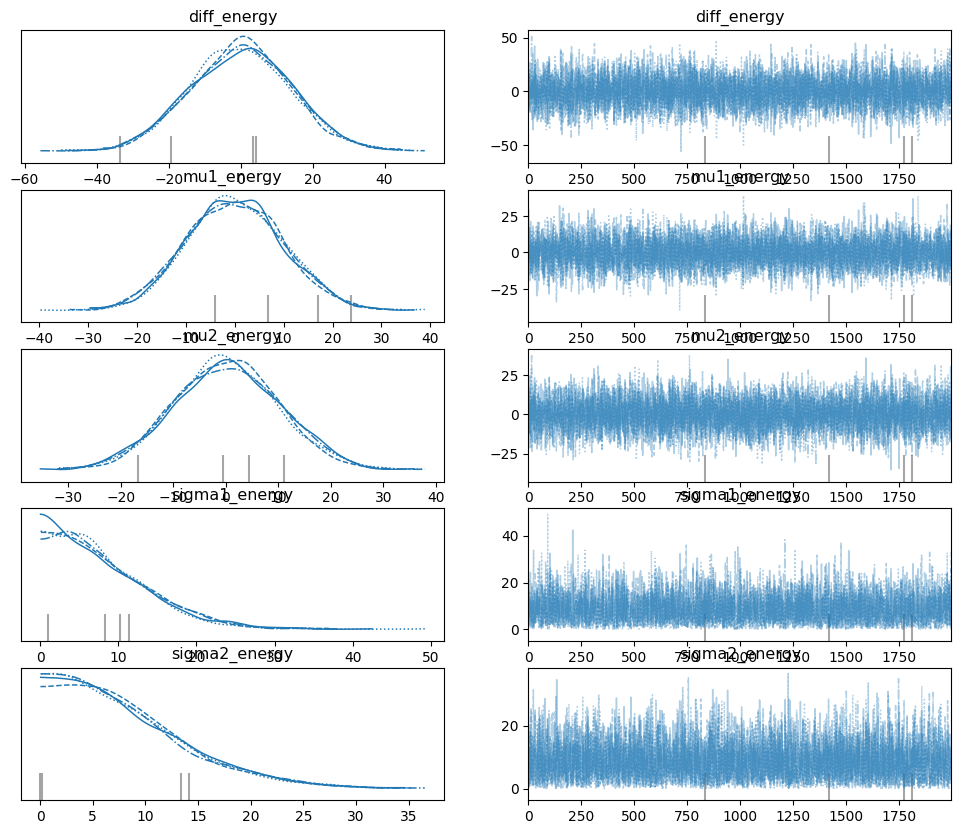

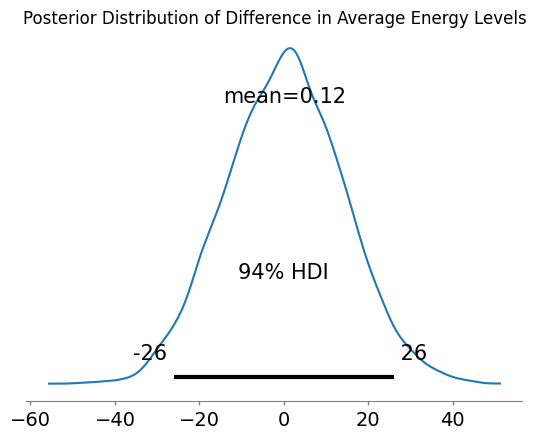

In [68]:
analyze_energy_levels(data, '2024-05-29', '2024-06-28', 'sleep_duration')